# Th analysis

In [1]:
%matplotlib inline

import os
import random
import sys
import textwrap

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
import tables as tb

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.paolina_functions as plf

from   collections                             import namedtuple
from   invisible_cities.io.hits_io             import load_hits
from   invisible_cities.io.hits_io             import load_hits_skipping_NN
from   invisible_cities.evm.event_model        import Hit, Cluster, HitCollection
from   invisible_cities.types.ic_types         import xy
from   invisible_cities.types.ic_types         import NN
from   invisible_cities.core.system_of_units_c import units
from   matplotlib.patches                      import Ellipse
from   mpl_toolkits.mplot3d                    import Axes3D

In [160]:
def gaussexpo(x, amp, mu, sigma, const, mean, x0):

    if sigma <= 0.:
        return np.inf
    
    return amp/(2*np.pi)**.5/sigma * np.exp(-0.5*(x-mu)**2./sigma**2.) + const * np.exp((x-x0)/mean)

# code from Gonzalo
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (1592/2458)**0.5

def gausstext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values)))

def gaussexpotext(values):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        $\\bar x$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:3], values[4], *reso(values[0:3])))

## Read the corrections table
Reads the corrections table from the specified file and creates a function that returns the correction factor for a given (x,y) location.

In [3]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4168/run4168_corrections.h5"
ncbins = 54

Correction table with shape: (50, 50); bin sizes (7.9199981689453125,7.9199981689453125)


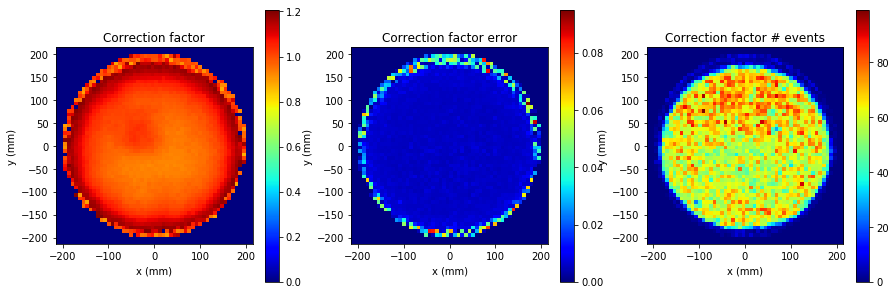

In [4]:
fcorr = tb.open_file(corr_file,'r')

# Fill arrays containing the information in the correction table.
corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf = np.max(corr_fs)

# ---------------------------------------------
# Plots

fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor
ax1 = fig.add_subplot(131);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=maxf)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(132)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics
ax3 = fig.add_subplot(133)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (ncbins, ncbins), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

# get the x and y bin sizes
xdiff = corr_x[1:] - corr_x[0:-1]
nz_xdiff = np.nonzero(xdiff)[0]
xbin = xdiff[nz_xdiff][0]
xcmin = np.min(corr_x)

ydiff = corr_y[1:] - corr_y[0:-1]
nz_ydiff = np.nonzero(ydiff)[0]
ybin = ydiff[np.nonzero(ydiff)][0]
ycmin = np.min(corr_y)

# ---------------------------------------------------
# Create the correction factor table.

ctbl = np.ones([len(nz_xdiff)+1,len(nz_xdiff)+1])-2
for x,y,fs in zip(corr_x,corr_y,corr_fs):
    xb = int((x-xcmin)/xbin)
    yb = int((y-ycmin)/ybin)
    ctbl[xb][yb] = fs
    #print("Filled ({0},{1}) with {2} for x = {3} and y = {4}".format(xb,yb,fs,x,y))
if(len(ctbl[ctbl < 0]) > 0):
    print("ERROR: value in correction table not filled")
print("Correction table with shape: {0}; bin sizes ({1},{2})".format(ctbl.shape,xbin,ybin))

# Define a function that returns the correction factor for a given (x,y).
def fcorr(x,y):
    xb = max(0,min(ctbl.shape[0]-1,((x-xcmin)/xbin).astype(int)))
    yb = max(0,min(ctbl.shape[1]-1,((y-ycmin)/ybin).astype(int)))

    if hasattr(xb, "__len__"):
        cf = [ctbl[xx][yy] for xx,yy in zip(xb,yb)]
        return cf
    else:
        return ctbl[xb][yb]

## Read in the output of Penthesilea
Reads in Penthesilea output from the runs listed

In [5]:
def merge_NN_hits(hits_all,hits_nonNN):

    # Iterate through both dictionaries (note - assuming same number of events)
    for (evt_all,hc_all),(evt,hc) in zip(hits_all.items(),hits_nonNN.items()):

        if(evt_all != evt):
            print("ERROR: events don't match!")
            
        # Add energy from all NN hits to hits in closest slice.
        for h1 in hc_all.hits:

            if(h1.Q == NN):

                # Find the hits to which the energy will be added.
                zdist_min = -1
                h_add = []
                for h2 in hc.hits:
                    zdist = np.abs(h1.Z - h2.Z)
                    if(zdist_min < 0 or zdist < zdist_min):
                        zdist_min = zdist
                        h_add = []
                        h_add.append(h2)
                    elif(zdist == zdist_min):
                        h_add.append(h2)

                # Add the energy.
                hadd_etot = sum([ha.E for ha in h_add])
                for ha in h_add:
                    ha.energy += h1.E*(ha.E/hadd_etot)
                    
        # Check the sum of the energy
        #e1 = sum([hh.E for hh in hc_all.hits])
        #e2 = sum([hh.E for hh in hc.hits])
        #if(abs(e1 - e2) > 0.001):
        #    print("ERROR")


In [6]:
l_rnum = [4595, 4597, 4599, 4601]
l_tlife = [1387, 1438, 1456, 1460]

In [7]:
l_hitc = []
for rnum in l_rnum:
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits_all = load_hits(fname)
    hits = load_hits_skipping_NN(fname)

    # Modifies the list of non-NN hits.
    merge_NN_hits(hits_all,hits)
    
    # Save the hit collection that no longer contains NN hits.
    l_hitc.append(hits)

In [8]:
# Configuration information
tot_Emin = 50000; tot_Emax = 1000000

In [9]:
# Create the corrected hit collection (summed over all runs).
hitc_cevt = []
for hitc, tlife in zip(l_hitc,l_tlife):

    for ee,hc in hitc.items():
        hc_corr = []
        for hh in hc.hits:
            hecorr = hh.E*fcorr(hh.X,hh.Y)/np.exp(-hh.Z/tlife)
            hcorr = Hit(0,Cluster(0, xy(hh.X,hh.Y), xy(0,0), 0),hh.Z,hecorr)
            hc_corr.append(hcorr)
        hitc_cevt.append(hc_corr)

---------------------------

# Distributions and analysis of all events
At this point we have a list of hit collections for all events from all specified runs, corrected by their appropriate lifetimes.  Here we extract key information from these hits.

In [10]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    if(evt_E > tot_Emin and evt_E < tot_Emax):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


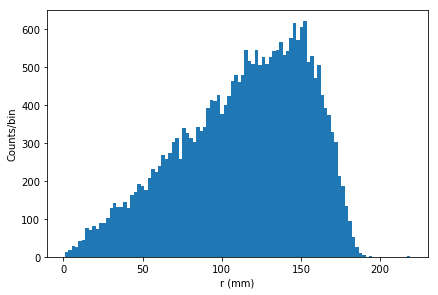

In [11]:
# Distribution in R
fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

# event distribution vs. R
ax1 = fig.add_subplot(221);
plt.hist(rc_spec,bins=100)
plt.xlabel('r (mm)')
plt.ylabel('Counts/bin')

/Users/jrenner/IFIC/IC-1/invisible_cities/core/fit_functions.py:28: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(cov))


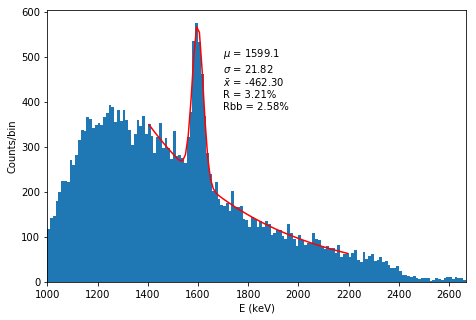

In [162]:
# closer look at the energy spectrum
CAL_FACTOR = 1620/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(ec_spec*CAL_FACTOR, 150, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
#sel  = fitf.in_range(x, 467e3*CAL_FACTOR, 494e3*CAL_FACTOR)
sel  = fitf.in_range(x, 1400, 2200)
x, y = x[sel], y[sel]
f    = fitf.fit(gaussexpo, x, y, (550, 1600, 100, 500, -600, 1200))
#f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
plt.plot(x, f.fn(x), "r")
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))
plt.text(510000*CAL_FACTOR, 4*max(y)/6, gaussexpotext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

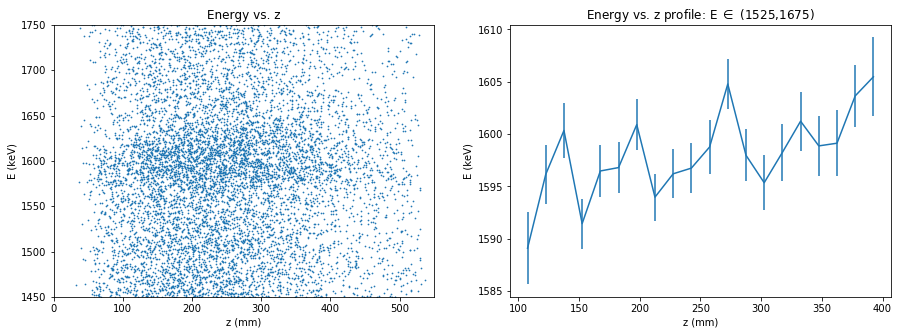

In [181]:
# Energy vs. z
zmin = 1525
zmax = 1675
zprof, Eprof, Eerr = fitf.profileX(zc_spec,ec_spec*CAL_FACTOR,nbins=20,xrange=(100,400),yrange=(zmin,zmax))

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
ax1.scatter(zc_spec,ec_spec*CAL_FACTOR,s=0.5)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
plt.title("Energy vs. z")
plt.ylim([1450,1750])
plt.xlim([0,550])
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

ax2 = fig.add_subplot(122);
ax2.errorbar(zprof,Eprof,yerr=Eerr)
#plt.scatter(range(len(ec_spec)),ec_spec*CAL_FACTOR,s=0.5)
#plt.ylim([100000,900000])
#plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.title("Energy vs. z profile: E $\in$ ({0},{1})".format(zmin,zmax))
plt.xlabel('z (mm)')
plt.ylabel('E (keV)')

# Paolina analysis

In [91]:
vol_min = np.array([-250, -250, -100],dtype=np.int16)  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 400],dtype=np.int16)  # volume maximum (x,y,z)
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm
ECCUT_LOW = 250000
ECCUT_HIGH = 1000000
DIST_CUT = 60.
EBLOB_CUT = 300000    # do not accept events with a single blob > this energy

In [92]:
# run Paolina for many events
trk_energies = []; 
l_eblob1 = []; l_eblob2 = []; l_eevt = []; l_etrk = []
for nevt in range(len(hitc_cevt)):
    
    hitc = hitc_cevt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[nevt]])
    evt_E = sum([hh.E for hh in hitc_cevt[nevt]])
    if(len(hitc_cevt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    
    # Make energy and radial cuts.
    if(not (evt_E > ECCUT_LOW and evt_E < ECCUT_HIGH) or evt_R >= 150.):
        continue

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    #itmax = np.argmax([len(t) for t in trks])
    itmax = np.argmax([sum([vox.E for vox in t.nodes()]) for t in trks])
    etmax = sum([vox.E for vox in trks[itmax].nodes()])
    
    # voxel fraction cut
    #if(len(trks[itmax])/len(voxels) < 0.95):
    #    continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_cevt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add to the distributions if the blob energy does not exceed the upper limit
    if(Eblob1 < EBLOB_CUT and Eblob2 < EBLOB_CUT):
        l_eblob1.append(Eblob1)
        l_eblob2.append(Eblob2)
        l_eevt.append(evt_E)
        l_etrk.append(etmax)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)
l_eevt = np.array(l_eevt)
l_etrk = np.array(l_etrk)

Track 0 with 41 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 69.98942685898184
Track 1 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 158.3493504309908
Track 2 with 70 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 33 voxels, distance = 119.49326827175813
Track 3 with 56 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 276.37826733321094
Track 4 with 44 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 237.6881180173668
Track 5 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 134.67718077273216
Track 6 with 42 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 84.48853132267749
Track 7 with 45 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 27 voxels, distance = 86.93092082401961
Track

Track 89 with 61 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 29 voxels, distance = 77.6875405240815
Track 90 with 31 hits...
Track 91 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 112.13184475344788
Track 92 with 39 hits...
Track 93 with 39 hits...
Track 94 with 53 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 105.4632910673948
Track 95 with 23 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 10 voxels, distance = 62.317616364805374
Track 96 with 45 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 72.93220636299932
Track 97 with 41 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 63.292397751712755
Track 99 with 31 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 134.4760101277222
Track 100 with 47 hits...
Found 2 tracks of 26560

Found 2 tracks of 26560; max containing 31 voxels; total of 32 voxels, distance = 261.90976039772875
Track 188 with 52 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 28 voxels, distance = 92.11364719386103
Track 189 with 54 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 28 voxels, distance = 183.11836327790775
Track 190 with 29 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 19 voxels, distance = 129.48257747097944
Track 192 with 41 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 23 voxels, distance = 87.75083600883909
Track 194 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 116.01205263176072
Track 195 with 34 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 97.39635819695819
Track 196 with 26 hits...
Track 197 with 46 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 26 voxels, distance = 164.05

Found 2 tracks of 26560; max containing 31 voxels; total of 34 voxels, distance = 255.29219783012402
Track 281 with 49 hits...
Found 3 tracks of 26560; max containing 24 voxels; total of 26 voxels, distance = 83.7708304774306
Track 282 with 47 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 85.47418420232165
Track 283 with 28 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 88.77875534423032
Track 284 with 26 hits...
Track 285 with 42 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 152.1032049052229
Track 286 with 31 hits...
Track 288 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 141.13581610226709
Track 289 with 50 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 104.6420898555478
Track 290 with 32 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 vo

Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 187.04921123627992
Track 371 with 35 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 200.77291910432666
Track 372 with 52 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 234.8165967320372
Track 373 with 46 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 84.09908855053416
Track 374 with 39 hits...
Track 375 with 46 hits...
Track 376 with 44 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 27 voxels, distance = 116.5893138274067
Track 377 with 39 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 171.27996607443075
Track 378 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 88.45232195160976
Track 379 with 46 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 124.24020528327733
Track 468 with 45 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 23 voxels, distance = 88.1024633745755
Track 469 with 47 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 148.35566468811282
Track 470 with 46 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 151.06596732782123
Track 471 with 30 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 19 voxels, distance = 67.88500023466842
Track 472 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 201.27135259547606
Track 473 with 50 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 167.39386407945503
Track 474 with 31 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 100.81811427441882
Track 475 with

Found 3 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 124.90920893636272
Track 554 with 38 hits...
Track 555 with 48 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 240.51276671193907
Track 556 with 46 hits...
Track 557 with 45 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 139.581870113524
Track 559 with 33 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 119.15901314429235
Track 560 with 85 hits...
Found 1 tracks of 26560; max containing 42 voxels; total of 42 voxels, distance = 390.687477663083
Track 561 with 46 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 202.35097729974473
Track 562 with 66 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 163.03073728653163
Track 563 with 50 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 26 

Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 88.33182967469372
Track 651 with 31 hits...
Track 652 with 34 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 14 voxels, distance = 69.67055304899152
Track 653 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 111.38602322989033
Track 654 with 44 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 23 voxels, distance = 95.45569136987456
Track 655 with 41 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 160.701408202722
Track 656 with 75 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 39 voxels, distance = 191.35109228941909
Track 659 with 58 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 103.6964955950204
Track 663 with 45 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 21 voxels, distance = 63.63643499

Found 4 tracks of 26560; max containing 23 voxels; total of 26 voxels, distance = 99.3249878321461
Track 745 with 30 hits...
Found 3 tracks of 26560; max containing 6 voxels; total of 13 voxels, distance = 69.72301747953296
Track 746 with 58 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 281.5186813465474
Track 747 with 47 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 92.44264590998023
Track 749 with 52 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 179.3544544046169
Track 750 with 30 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 101.09677011832834
Track 751 with 39 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 139.57306260160914
Track 752 with 36 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 117.3109660428633
Track 753 with 29 

Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 217.4647901264792
Track 838 with 52 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 130.83392767525888
Track 839 with 35 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 115.03523743035355
Track 841 with 67 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 32 voxels, distance = 262.84142659935736
Track 842 with 23 hits...
Track 843 with 42 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 87.14683837999448
Track 844 with 54 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 76.89715221213302
Track 845 with 46 hits...
Track 846 with 58 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 26 voxels, distance = 101.27893651146059
Track 847 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17

Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 211.19313996292027
Track 929 with 57 hits...
Found 7 tracks of 26560; max containing 11 voxels; total of 29 voxels, distance = 125.31082332002914
Track 930 with 27 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 105.5396338495122
Track 933 with 49 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 107.60024185237127
Track 934 with 44 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 92.17762230221446
Track 935 with 43 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 18 voxels, distance = 75.19150192336788
Track 936 with 37 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 138.23421170454364
Track 937 with 38 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 164.59274929811045
Track 938 with

Found 3 tracks of 26560; max containing 24 voxels; total of 26 voxels, distance = 99.55581885657506
Track 1019 with 40 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 69.39490100958639
Track 1020 with 51 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 127.50796667178602
Track 1021 with 38 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 70.1014530793304
Track 1023 with 60 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 193.42763935866293
Track 1024 with 40 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 150.1247925141485
Track 1026 with 40 hits...
Track 1027 with 50 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 61.212144904853496
Track 1029 with 60 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 

Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 153.33426991389308
Track 1103 with 42 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 93.52980383674122
Track 1104 with 35 hits...
Track 1105 with 48 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 187.97111508237123
Track 1107 with 33 hits...
Track 1108 with 59 hits...
Found 3 tracks of 26560; max containing 30 voxels; total of 36 voxels, distance = 214.72666320779038
Track 1109 with 33 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 104.38726822934089
Track 1110 with 41 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 128.36845449970707
Track 1111 with 26 hits...
Found 3 tracks of 26560; max containing 6 voxels; total of 14 voxels, distance = 72.92660828127923
Track 1112 with 62 hits...
Found 3 tracks of 26560; max containing 12 voxels; to

Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 107.89227009343186
Track 1198 with 31 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 84.63847607273934
Track 1199 with 36 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 91.79353512032058
Track 1200 with 34 hits...
Found 3 tracks of 26560; max containing 6 voxels; total of 12 voxels, distance = 61.93903503786949
Track 1201 with 34 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 113.19904183402541
Track 1203 with 34 hits...
Track 1204 with 42 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 83.30582932257839
Track 1205 with 29 hits...
Track 1206 with 56 hits...
Found 6 tracks of 26560; max containing 19 voxels; total of 33 voxels, distance = 86.58056573555807
Track 1207 with 49 hits...
Found 4 tracks of 26560; max containing 9 voxels; total 

Found 2 tracks of 26560; max containing 20 voxels; total of 24 voxels, distance = 88.82199240952266
Track 1286 with 40 hits...
Track 1287 with 30 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 107.03610261668757
Track 1288 with 33 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 17 voxels, distance = 116.12877602781185
Track 1289 with 41 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 132.2136698182834
Track 1290 with 53 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 245.66168235256416
Track 1292 with 49 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 29 voxels, distance = 106.64689218754069
Track 1293 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 88.4941803911188
Track 1294 with 45 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance =

Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 162.4483138510876
Track 1399 with 37 hits...
Track 1400 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 147.81925767788152
Track 1401 with 51 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 26 voxels, distance = 134.01105513882925
Track 1402 with 40 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 189.7643743084222
Track 1403 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 158.6410544149739
Track 1404 with 29 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 114.43246169199274
Track 1405 with 68 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 35 voxels, distance = 250.9498126526798
Track 1406 with 49 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance =

Track 1491 with 34 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 147.95052321233794
Track 1492 with 48 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 24 voxels, distance = 96.1974155839491
Track 1493 with 27 hits...
Track 1494 with 38 hits...
Track 1495 with 36 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 86.7132271963608
Track 1496 with 37 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 74.84393025812818
Track 1497 with 44 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 19 voxels, distance = 142.4254501946046
Track 1498 with 34 hits...
Found 3 tracks of 26560; max containing 7 voxels; total of 13 voxels, distance = 68.31281794995776
Track 1499 with 61 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 262.46923553362626
Track 1500 with 49 hits...
Track 1503 with 46 hits...
Foun

Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 78.17471796302875
Track 1585 with 57 hits...
Track 1587 with 45 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 137.9579403001828
Track 1588 with 23 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 13 voxels, distance = 73.69062872782027
Track 1589 with 41 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 80.5184576998
Track 1590 with 42 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 78.02251140687589
Track 1591 with 26 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 84.00804127586235
Track 1592 with 25 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 76.37788005513445
Track 1593 with 49 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 210.887

Track 1674 with 47 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 84.80589912361607
Track 1677 with 29 hits...
Track 1678 with 59 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 182.50543593393297
Track 1679 with 29 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 14 voxels, distance = 90.60560604772465
Track 1680 with 36 hits...
Track 1682 with 45 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 21 voxels, distance = 86.34940164758854
Track 1684 with 26 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 94.31965622061895
Track 1685 with 46 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 114.19358173760573
Track 1686 with 52 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 135.5151170493221
Track 1687 with 31 hits...
Found 1 tracks of 26560; max

Track 1771 with 43 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 123.15877573294351
Track 1772 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 102.45744381342219
Track 1773 with 55 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 151.72270861968718
Track 1774 with 84 hits...
Found 3 tracks of 26560; max containing 37 voxels; total of 40 voxels, distance = 202.464268424746
Track 1775 with 52 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 25 voxels, distance = 124.58824570493336
Track 1776 with 51 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 142.50391763735232
Track 1777 with 47 hits...
Found 7 tracks of 26560; max containing 9 voxels; total of 19 voxels, distance = 84.50500991973182
Track 1778 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance =

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 230.1202972405199
Track 1855 with 44 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 26 voxels, distance = 85.1735533204185
Track 1856 with 57 hits...
Found 3 tracks of 26560; max containing 28 voxels; total of 32 voxels, distance = 160.90612556216558
Track 1859 with 65 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 32 voxels, distance = 143.50238761734045
Track 1861 with 51 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 192.5899158316575
Track 1862 with 40 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 118.02674707319113
Track 1863 with 52 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 25 voxels, distance = 178.38688185545516
Track 1866 with 44 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 130.7071136000774
Track 18

Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 112.40034863777277
Track 1950 with 43 hits...
Track 1951 with 41 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 20 voxels, distance = 68.48717134518995
Track 1952 with 62 hits...
Found 9 tracks of 26560; max containing 11 voxels; total of 34 voxels, distance = 78.83975791394728
Track 1953 with 42 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 20 voxels, distance = 78.6520960539272
Track 1954 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 65.38889117654927
Track 1955 with 44 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 157.74371264493314
Track 1956 with 32 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 127.81579261158677
Track 1957 with 48 hits...
Found 5 tracks of 26560; max containing 9 voxels; total of 22 voxels, distance = 1

Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 70.25777713933917
Track 2035 with 31 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 153.69862914512666
Track 2036 with 39 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance = 73.69998235577854
Track 2037 with 32 hits...
Track 2038 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 128.72238434037806
Track 2039 with 37 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 19 voxels, distance = 97.89081909944055
Track 2040 with 58 hits...
Found 1 tracks of 26560; max containing 34 voxels; total of 34 voxels, distance = 233.15061695794293
Track 2044 with 44 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 107.61295916462656
Track 2045 with 44 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 22 voxels, distance =

Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 88.37153254051933
Track 2135 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 99.56348384126522
Track 2136 with 55 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 31 voxels, distance = 105.2302541875846
Track 2137 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 91.0198537808933
Track 2139 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 96.34602861665677
Track 2140 with 53 hits...
Track 2141 with 31 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 16 voxels, distance = 67.99888610704757
Track 2142 with 33 hits...
Track 2143 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 109.54568046849928
Track 2144 with 71 hits...
Found 3 tracks of 26560; max containing 24 voxels; total o

Track 2216 with 28 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 112.66220255356805
Track 2217 with 72 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 31 voxels, distance = 221.56371467154264
Track 2219 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 135.9180223890616
Track 2222 with 52 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 149.57005857185086
Track 2223 with 39 hits...
Track 2224 with 35 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 87.46845993536601
Track 2225 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 83.87107309028436
Track 2226 with 29 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 66.83024687456984
Track 2227 with 42 hits...
Found 1 tracks of 26560; max containing 24 voxels; tot

Found 4 tracks of 26560; max containing 8 voxels; total of 17 voxels, distance = 72.08825915736927
Track 2323 with 39 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 120.84937390963721
Track 2324 with 45 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 120.62449891780196
Track 2325 with 35 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 69.04598739052543
Track 2327 with 35 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 81.1978904186646
Track 2328 with 44 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 84.25315305395785
Track 2330 with 52 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 122.77397688105462
Track 2332 with 37 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 97.30024666589037
Track 2334

Found 3 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 131.97661132134613
Track 2411 with 37 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 15 voxels, distance = 82.41957214117296
Track 2412 with 45 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 18 voxels, distance = 66.30311067039572
Track 2413 with 37 hits...
Track 2414 with 60 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 320.8379475421274
Track 2415 with 41 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 141.58167440894022
Track 2416 with 62 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 168.35857205474383
Track 2417 with 52 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 27 voxels, distance = 69.48818915454711
Track 2419 with 29 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 

Found 3 tracks of 26560; max containing 22 voxels; total of 31 voxels, distance = 89.59501221091838
Track 2494 with 43 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 147.57251201314045
Track 2495 with 29 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 74.36962603094287
Track 2496 with 42 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 20 voxels, distance = 60.94485165773793
Track 2497 with 65 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 33 voxels, distance = 167.8419331589706
Track 2498 with 55 hits...
Found 8 tracks of 26560; max containing 9 voxels; total of 28 voxels, distance = 69.0753446302395
Track 2499 with 29 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 90.79615435209219
Track 2500 with 34 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 17 voxels, distance = 75.87764991630614
Track 2501 wi

Found 2 tracks of 26560; max containing 32 voxels; total of 33 voxels, distance = 284.9167233626951
Track 2580 with 34 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 21 voxels, distance = 96.2851083726824
Track 2581 with 53 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 184.70515888690784
Track 2582 with 61 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 128.9697081573265
Track 2585 with 33 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 70.62135918532232
Track 2586 with 41 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 23 voxels, distance = 179.87671801168378
Track 2587 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 127.0836920552186
Track 2588 with 50 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 169.78178466787068
Track 258

Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 82.95353943090134
Track 2666 with 61 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 93.15636967941214
Track 2667 with 30 hits...
Track 2668 with 27 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 9 voxels, distance = 62.43449361121
Track 2669 with 53 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 30 voxels, distance = 157.03091090727443
Track 2670 with 66 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 266.8868906419911
Track 2671 with 32 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 137.46398440119896
Track 2672 with 54 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 108.26245706927645
Track 2673 with 44 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance = 67.2

Found 2 tracks of 26560; max containing 23 voxels; total of 33 voxels, distance = 136.87717649937287
Track 2757 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 117.76297339792616
Track 2761 with 50 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 158.84239195514715
Track 2762 with 25 hits...
Track 2763 with 40 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 22 voxels, distance = 85.11367635440837
Track 2764 with 34 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 76.13229561418618
Track 2766 with 48 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 118.61119313500826
Track 2767 with 62 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 33 voxels, distance = 219.70131255377797
Track 2769 with 35 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance

Found 4 tracks of 26560; max containing 25 voxels; total of 35 voxels, distance = 112.34460642239702
Track 2850 with 39 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 127.75763734678586
Track 2852 with 85 hits...
Found 2 tracks of 26560; max containing 33 voxels; total of 43 voxels, distance = 146.46021680688966
Track 2853 with 35 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 86.0809273536719
Track 2854 with 41 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 119.62196912777989
Track 2855 with 47 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 126.59290002827785
Track 2856 with 54 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 28 voxels, distance = 156.03222185504376
Track 2858 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 72.16948992802791
Track 

Track 2944 with 63 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 140.13572259278652
Track 2946 with 37 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 119.21882802516268
Track 2947 with 28 hits...
Found 2 tracks of 26560; max containing 7 voxels; total of 11 voxels, distance = 65.4383635616221
Track 2948 with 65 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 40 voxels, distance = 85.09133841732637
Track 2949 with 34 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 104.9337293240711
Track 2950 with 47 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 26 voxels, distance = 141.35288489542862
Track 2952 with 38 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 114.33178425222619
Track 2953 with 39 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 

Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 135.01356731209154
Track 3037 with 67 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 34 voxels, distance = 167.8953213309753
Track 3038 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 106.50539086454026
Track 3039 with 40 hits...
Track 3040 with 65 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 228.3604513024112
Track 3041 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 157.59137622537529
Track 3042 with 53 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 27 voxels, distance = 98.25275060407388
Track 3043 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 120.09302096649674
Track 3044 with 32 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 12 voxels, distance =

Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 131.61249849878698
Track 3123 with 32 hits...
Track 3124 with 41 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 136.05040702249252
Track 3125 with 38 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 15 voxels, distance = 75.49873439570497
Track 3126 with 64 hits...
Found 4 tracks of 26560; max containing 21 voxels; total of 27 voxels, distance = 189.60044417445854
Track 3127 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 110.48062103698003
Track 3128 with 47 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 140.73991255382
Track 3129 with 78 hits...
Found 2 tracks of 26560; max containing 34 voxels; total of 36 voxels, distance = 223.17706316927095
Track 3130 with 41 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance =

Found 3 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 76.7903870919865
Track 3224 with 33 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 69.10152006686326
Track 3225 with 20 hits...
Track 3226 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 98.29410332056202
Track 3227 with 29 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 11 voxels, distance = 71.60069506387107
Track 3230 with 44 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 28 voxels, distance = 95.08371122970415
Track 3231 with 43 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 82.61025817092874
Track 3232 with 56 hits...
Found 3 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 161.90690580226155
Track 3233 with 47 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 24 voxels, distance = 64

Found 2 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 103.73256465347997
Track 3318 with 36 hits...
Track 3319 with 44 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 88.76776696449573
Track 3320 with 32 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 85.18650146539646
Track 3322 with 26 hits...
Track 3323 with 69 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 33 voxels, distance = 98.43454956369348
Track 3324 with 27 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 105.54829728046136
Track 3325 with 40 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 70.7624819743295
Track 3326 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 93.34630691932736
Track 3327 with 54 hits...
Found 1 tracks of 26560; max containing 25 voxels; total

Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 89.60228278126155
Track 3408 with 44 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 92.44654424581441
Track 3410 with 62 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 217.2575041299817
Track 3411 with 29 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 71.87094652358948
Track 3412 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 96.95118043711312
Track 3413 with 49 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 76.23070826129208
Track 3414 with 61 hits...
Found 4 tracks of 26560; max containing 22 voxels; total of 32 voxels, distance = 171.03145156343652
Track 3416 with 44 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 129.6683622176562
Track 3417

Found 3 tracks of 26560; max containing 31 voxels; total of 38 voxels, distance = 198.31054510813289
Track 3505 with 32 hits...
Track 3507 with 52 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 201.0516470399886
Track 3508 with 61 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 31 voxels, distance = 264.2136058506438
Track 3509 with 41 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 67.0714187770745
Track 3510 with 37 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 114.0708351974415
Track 3511 with 52 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 81.24533574801342
Track 3512 with 48 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 78.27034536662106
Track 3514 with 28 hits...
Track 3515 with 60 hits...
Found 4 tracks of 26560; max containing 20 voxels; total 

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 135.72949253933336
Track 3594 with 44 hits...
Found 5 tracks of 26560; max containing 13 voxels; total of 24 voxels, distance = 117.85517850513999
Track 3595 with 43 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 132.75677881051007
Track 3596 with 49 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 60.932370988002006
Track 3597 with 46 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 138.6187679192821
Track 3598 with 35 hits...
Track 3599 with 53 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 136.0622323426188
Track 3600 with 33 hits...
Track 3602 with 41 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 110.65466867775436
Track 3603 with 50 hits...
Found 3 tracks of 26560; max containing 14 voxels; t

Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 124.07674903923377
Track 3682 with 34 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 18 voxels, distance = 93.26202768248254
Track 3684 with 45 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 22 voxels, distance = 70.45572556853175
Track 3685 with 42 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 131.24659108475382
Track 3686 with 47 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 82.14099379457647
Track 3687 with 40 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 134.42335975693072
Track 3689 with 28 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 116.69891202224154
Track 3690 with 39 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 111.4203540286243
Track 36

Track 3771 with 71 hits...
Found 1 tracks of 26560; max containing 35 voxels; total of 35 voxels, distance = 277.43514369714336
Track 3772 with 73 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 31 voxels, distance = 81.62305886187218
Track 3773 with 40 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 78.84735815322516
Track 3776 with 28 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 90.64522094732223
Track 3780 with 45 hits...
Found 5 tracks of 26560; max containing 19 voxels; total of 24 voxels, distance = 104.91897030914154
Track 3781 with 46 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 132.61552410774772
Track 3782 with 43 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 130.5679867944001
Track 3783 with 63 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 35 voxels, distance = 

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 205.9019194805325
Track 3869 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 111.68254830266274
Track 3870 with 49 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 28 voxels, distance = 154.12849684822189
Track 3871 with 33 hits...
Track 3872 with 52 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 157.88665893585653
Track 3873 with 30 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 11 voxels, distance = 77.16368942347182
Track 3874 with 33 hits...
Track 3875 with 69 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 29 voxels, distance = 133.9212128035136
Track 3876 with 47 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 117.20960439576531
Track 3877 with 41 hits...
Found 1 tracks of 26560; max containing 17 voxels; tot

Track 3949 with 38 hits...
Track 3950 with 39 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 147.03855578114593
Track 3951 with 71 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 37 voxels, distance = 128.69668352927056
Track 3952 with 40 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 102.81872657549914
Track 3953 with 50 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 28 voxels, distance = 60.27549693027551
Track 3954 with 30 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 104.28618936703106
Track 3955 with 37 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 18 voxels, distance = 68.55760308071508
Track 3956 with 41 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 112.2166039961921
Track 3957 with 59 hits...
Found 2 tracks of 26560; max containing 15 voxels; tot

Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 70.57024571749317
Track 4033 with 62 hits...
Found 10 tracks of 26560; max containing 9 voxels; total of 35 voxels, distance = 76.10049848254724
Track 4034 with 37 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 73.03264150861025
Track 4036 with 34 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 69.84846262683558
Track 4040 with 42 hits...
Track 4041 with 46 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 25 voxels, distance = 134.34385597149554
Track 4042 with 42 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 22 voxels, distance = 91.55843855365252
Track 4043 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 119.3189406603942
Track 4044 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 1

Track 4130 with 41 hits...
Found 5 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 110.1461426224262
Track 4132 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 98.18574450479478
Track 4133 with 48 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 102.49380053286349
Track 4134 with 35 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 124.594884413327
Track 4135 with 49 hits...
Track 4136 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 151.97421892859023
Track 4139 with 66 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 31 voxels, distance = 79.50813025573832
Track 4140 with 34 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 17 voxels, distance = 119.12920892702778
Track 4141 with 35 hits...
Found 2 tracks of 26560; max containing 14 voxels; total

Found 5 tracks of 26560; max containing 13 voxels; total of 25 voxels, distance = 73.43138942305936
Track 4222 with 39 hits...
Track 4224 with 39 hits...
Track 4226 with 39 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 135.77639854992398
Track 4227 with 38 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 92.62912463569145
Track 4228 with 47 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 72.42409019037086
Track 4229 with 30 hits...
Track 4230 with 44 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 99.27606410132233
Track 4231 with 52 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 285.6922798659287
Track 4232 with 38 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 86.17788197107129
Track 4234 with 36 hits...
Found 1 tracks of 26560; max 

Found 5 tracks of 26560; max containing 22 voxels; total of 28 voxels, distance = 90.2137084142808
Track 4311 with 62 hits...
Found 5 tracks of 26560; max containing 14 voxels; total of 25 voxels, distance = 129.95038702139493
Track 4312 with 63 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 27 voxels, distance = 114.04097004929561
Track 4313 with 33 hits...
Track 4314 with 68 hits...
Found 1 tracks of 26560; max containing 39 voxels; total of 39 voxels, distance = 296.7175841599784
Track 4315 with 89 hits...
Found 2 tracks of 26560; max containing 35 voxels; total of 36 voxels, distance = 318.0049881768095
Track 4316 with 43 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 157.52621071088444
Track 4317 with 52 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 120.78778209268447
Track 4318 with 45 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance =

Track 4399 with 25 hits...
Track 4400 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 195.78729270722204
Track 4401 with 23 hits...
Track 4402 with 48 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 183.52435077332885
Track 4403 with 42 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 97.53282809275397
Track 4404 with 47 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 96.54267762001102
Track 4405 with 61 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 25 voxels, distance = 70.54205666155593
Track 4406 with 48 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 23 voxels, distance = 69.99144996874931
Track 4409 with 48 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 172.94541256461943
Track 4410 with 33 hits...
Track 4413 with 31 hits...


Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 129.22672813491124
Track 4499 with 49 hits...
Found 3 tracks of 26560; max containing 24 voxels; total of 30 voxels, distance = 144.0678396576444
Track 4500 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 187.00786926667865
Track 4501 with 43 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 23 voxels, distance = 102.38816448538799
Track 4502 with 70 hits...
Found 3 tracks of 26560; max containing 27 voxels; total of 31 voxels, distance = 202.9742859528544
Track 4503 with 58 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 27 voxels, distance = 124.63952247576424
Track 4504 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 89.26855126100634
Track 4505 with 49 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 24 voxels, distance = 133.0227862080638
Track 4

Track 4580 with 29 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 14 voxels, distance = 65.01082322658712
Track 4581 with 49 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 154.9011538543578
Track 4582 with 42 hits...
Track 4583 with 42 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 102.02859617508005
Track 4584 with 59 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 27 voxels, distance = 147.48373085180407
Track 4585 with 54 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 29 voxels, distance = 101.42582980273095
Track 4586 with 31 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 87.2568592113966
Track 4590 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 77.26658725818417
Track 4591 with 58 hits...
Found 2 tracks of 26560; max containing 20 voxels; total

Found 3 tracks of 26560; max containing 19 voxels; total of 28 voxels, distance = 129.76372727972324
Track 4674 with 23 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 11 voxels, distance = 92.42721285680355
Track 4675 with 36 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 75.5121939633621
Track 4676 with 40 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 84.9051194862695
Track 4677 with 65 hits...
Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 255.06987793230553
Track 4678 with 43 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 100.33231866780315
Track 4679 with 26 hits...
Track 4681 with 37 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 69.19550318427076
Track 4682 with 57 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 13

Found 2 tracks of 26560; max containing 25 voxels; total of 32 voxels, distance = 240.1086587681641
Track 4772 with 28 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 106.78636727714235
Track 4773 with 26 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 77.38167120763868
Track 4774 with 35 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 85.3351593832014
Track 4775 with 49 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 168.58363724591845
Track 4776 with 35 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 95.62224983033352
Track 4778 with 60 hits...
Found 1 tracks of 26560; max containing 34 voxels; total of 34 voxels, distance = 227.62496086358152
Track 4779 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 124.03096989395355
Track 47

Found 2 tracks of 26560; max containing 22 voxels; total of 34 voxels, distance = 288.27835446643155
Track 4871 with 34 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 78.25940877086337
Track 4872 with 59 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 30 voxels, distance = 82.14394065643403
Track 4873 with 53 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 27 voxels, distance = 80.1314905817972
Track 4874 with 49 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 206.1285523916892
Track 4875 with 33 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 93.4896610183069
Track 4876 with 53 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 27 voxels, distance = 87.82208078161297
Track 4877 with 45 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 23 voxels, distance = 100.56192012439439
Track 4878 

Found 3 tracks of 26560; max containing 7 voxels; total of 13 voxels, distance = 76.12284314728542
Track 4962 with 31 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 69.87662495233992
Track 4963 with 31 hits...
Track 4964 with 35 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 19 voxels, distance = 74.95223139671175
Track 4965 with 30 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 88.67946344916574
Track 4967 with 50 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 114.63100085360742
Track 4968 with 43 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 159.623472685364
Track 4969 with 41 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 134.67097645943198
Track 4970 with 35 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 15

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 134.3464515841156
Track 5050 with 33 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 91.17758283001623
Track 5051 with 51 hits...
Track 5053 with 38 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 76.18176024630321
Track 5054 with 49 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 22 voxels, distance = 72.67700758915578
Track 5055 with 44 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 100.66533429269211
Track 5057 with 33 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 85.56927555461006
Track 5058 with 43 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 122.20020631162447
Track 5059 with 29 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 

Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 89.76218352117043
Track 5145 with 37 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 79.31245204703684
Track 5146 with 52 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 92.33081655376796
Track 5147 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 135.41542756461712
Track 5148 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 93.38576565214721
Track 5149 with 52 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 117.15407949396278
Track 5151 with 35 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 104.81747680627684
Track 5152 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 182.8712997578046
Track 51

Found 3 tracks of 26560; max containing 15 voxels; total of 28 voxels, distance = 168.17148332352815
Track 5240 with 29 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 100.90068878705759
Track 5241 with 42 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 118.73574914798631
Track 5243 with 52 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 23 voxels, distance = 142.80416993027302
Track 5244 with 37 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 23 voxels, distance = 84.9590955820044
Track 5245 with 39 hits...
Found 4 tracks of 26560; max containing 7 voxels; total of 18 voxels, distance = 71.32878638836101
Track 5246 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 100.99687918443405
Track 5247 with 45 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 125.2537667995977
Track 52

Found 2 tracks of 26560; max containing 27 voxels; total of 31 voxels, distance = 219.4902222998408
Track 5325 with 43 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 134.7449379400197
Track 5326 with 56 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 19 voxels, distance = 143.56693527368878
Track 5327 with 49 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 102.68192469975821
Track 5328 with 32 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 85.75771995760716
Track 5329 with 61 hits...
Track 5330 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 110.16376586119833
Track 5333 with 48 hits...
Found 5 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 170.81892753167097
Track 5335 with 46 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 20 voxels, distance 

Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 203.16139696289935
Track 5422 with 51 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 25 voxels, distance = 204.02324571200634
Track 5423 with 40 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 159.45833690952813
Track 5424 with 40 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 65.57421083585997
Track 5425 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 89.99608927920096
Track 5426 with 59 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 130.08040167419705
Track 5427 with 72 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 31 voxels, distance = 120.08545301835056
Track 5428 with 55 hits...
Found 3 tracks of 26560; max containing 31 voxels; total of 34 voxels, distance = 152.3281932744678
Track 

Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 65.06004087214538
Track 5506 with 51 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 267.6345979118852
Track 5508 with 32 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 76.25591047514956
Track 5510 with 44 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 111.14689063889
Track 5512 with 70 hits...
Found 5 tracks of 26560; max containing 24 voxels; total of 32 voxels, distance = 102.54421940745692
Track 5513 with 41 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 152.24781572321515
Track 5514 with 47 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 125.21738053712906
Track 5515 with 40 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 132.02443700037003
Track 551

Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 87.29770125838613
Track 5604 with 25 hits...
Track 5605 with 69 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 33 voxels, distance = 187.94568519093386
Track 5607 with 39 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 16 voxels, distance = 87.53702568435918
Track 5609 with 42 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 168.26758948202874
Track 5610 with 63 hits...
Found 4 tracks of 26560; max containing 25 voxels; total of 35 voxels, distance = 131.7503635991657
Track 5611 with 34 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 89.28619254538137
Track 5612 with 50 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 27 voxels, distance = 117.0990848583798
Track 5613 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 

Found 3 tracks of 26560; max containing 16 voxels; total of 19 voxels, distance = 96.39942732645085
Track 5697 with 52 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 25 voxels, distance = 133.2211977399105
Track 5698 with 54 hits...
Found 7 tracks of 26560; max containing 14 voxels; total of 24 voxels, distance = 78.95795336924532
Track 5699 with 51 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 27 voxels, distance = 151.68134219973183
Track 5700 with 24 hits...
Track 5701 with 66 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 35 voxels, distance = 159.9603815737808
Track 5703 with 56 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 27 voxels, distance = 154.6354523009023
Track 5705 with 27 hits...
Track 5706 with 47 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 173.68797372604186
Track 5707 with 33 hits...
Found 1 tracks of 26560; max containing 14 voxels; tota

Found 2 tracks of 26560; max containing 24 voxels; total of 28 voxels, distance = 96.76386274777623
Track 5800 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 77.50313247434485
Track 5801 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 109.46127382047489
Track 5804 with 49 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 23 voxels, distance = 77.72310243705243
Track 5805 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 148.55201097844613
Track 5806 with 45 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 157.53866990113698
Track 5807 with 67 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 27 voxels, distance = 123.5358296150414
Track 5808 with 60 hits...
Found 4 tracks of 26560; max containing 26 voxels; total of 32 voxels, distance = 267.14176487757516
Track 5

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 176.068120332109
Track 5908 with 49 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 148.26553412909306
Track 5910 with 29 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 70.45520529082047
Track 5913 with 40 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 15 voxels, distance = 84.90266611294419
Track 5914 with 65 hits...
Found 3 tracks of 26560; max containing 27 voxels; total of 29 voxels, distance = 99.67853767412345
Track 5915 with 26 hits...
Track 5917 with 31 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 74.82972436773903
Track 5918 with 41 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 72.52798401373101
Track 5919 with 46 hits...
Track 5921 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total o

Found 2 tracks of 26560; max containing 28 voxels; total of 29 voxels, distance = 156.000024874168
Track 5994 with 31 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 112.17537221458255
Track 5995 with 40 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 159.8024749239956
Track 5996 with 64 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 28 voxels, distance = 220.40921173588643
Track 5998 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 136.4744581682173
Track 6000 with 56 hits...
Found 9 tracks of 26560; max containing 11 voxels; total of 28 voxels, distance = 68.92261893112666
Track 6001 with 51 hits...
Found 4 tracks of 26560; max containing 21 voxels; total of 27 voxels, distance = 142.28719028164986
Track 6002 with 28 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 83.6445695899493
Track 6003

Track 6095 with 55 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 196.5037875243433
Track 6096 with 36 hits...
Track 6098 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 76.2481560221316
Track 6099 with 46 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 134.29376605167585
Track 6101 with 38 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 117.86301496284088
Track 6102 with 33 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 94.41038768374739
Track 6103 with 55 hits...
Found 4 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 209.75154651662078
Track 6104 with 36 hits...
Track 6105 with 30 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 74.62904920064105
Track 6106 with 31 hits...
Track 6107 with 37 hits...
F

Found 2 tracks of 26560; max containing 32 voxels; total of 33 voxels, distance = 291.81891894676653
Track 6205 with 39 hits...
Track 6206 with 46 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 167.5543701739763
Track 6207 with 34 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 95.29093315975433
Track 6208 with 52 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 180.87951049686058
Track 6209 with 72 hits...
Found 2 tracks of 26560; max containing 35 voxels; total of 39 voxels, distance = 126.88572316224887
Track 6210 with 51 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 163.88241185649238
Track 6211 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 188.09074392434863
Track 6212 with 40 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance

Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 126.09597595857356
Track 6293 with 54 hits...
Found 7 tracks of 26560; max containing 12 voxels; total of 25 voxels, distance = 63.96402470925024
Track 6294 with 24 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 80.34332502379
Track 6295 with 31 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 111.14812134258152
Track 6296 with 36 hits...
Track 6297 with 45 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 22 voxels, distance = 142.53584188913393
Track 6298 with 42 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 101.25087377777952
Track 6299 with 64 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 31 voxels, distance = 156.00183911086248
Track 6300 with 40 hits...
Track 6301 with 37 hits...
Found 1 tracks of 26560; max containing 13 voxels; tota

Track 6383 with 39 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 86.30979068965405
Track 6384 with 36 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 93.29343626533392
Track 6387 with 38 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 128.80783755290125
Track 6388 with 55 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 27 voxels, distance = 108.05551995641798
Track 6389 with 31 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 131.17807922580394
Track 6390 with 53 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 204.26010136495108
Track 6391 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 119.85954099322942
Track 6392 with 36 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance

Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 92.02461265881213
Track 6486 with 51 hits...
Found 7 tracks of 26560; max containing 9 voxels; total of 26 voxels, distance = 114.43905151221642
Track 6487 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 104.88016336868992
Track 6488 with 35 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 109.34015576579228
Track 6490 with 40 hits...
Track 6491 with 56 hits...
Found 4 tracks of 26560; max containing 22 voxels; total of 27 voxels, distance = 118.69894009764535
Track 6492 with 30 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 13 voxels, distance = 88.60825132412582
Track 6495 with 36 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 18 voxels, distance = 73.34475588757006
Track 6496 with 41 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 

Found 3 tracks of 26560; max containing 28 voxels; total of 31 voxels, distance = 83.46850402330676
Track 6586 with 46 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 26 voxels, distance = 73.81188484442767
Track 6588 with 63 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 167.3110996737072
Track 6590 with 60 hits...
Track 6592 with 26 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 111.64441018776171
Track 6594 with 31 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 107.21898289681076
Track 6595 with 44 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 23 voxels, distance = 135.78987577262996
Track 6596 with 42 hits...
Track 6597 with 32 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 69.0326324267704
Track 6598 with 27 hits...
Track 6601 with 39 hits...
Found 1 tracks of 26560; max

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 195.4362383988949
Track 6684 with 31 hits...
Track 6685 with 28 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 71.83756982653577
Track 6687 with 30 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 75.11869140282843
Track 6688 with 42 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 95.0319576160477
Track 6690 with 38 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 105.95800836480397
Track 6691 with 39 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 99.8408433150623
Track 6692 with 38 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 80.22308349418478
Track 6693 with 55 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 123

Track 6777 with 55 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 93.24583091091219
Track 6778 with 47 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 25 voxels, distance = 60.240859450256785
Track 6779 with 44 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 114.30871472546539
Track 6780 with 69 hits...
Found 5 tracks of 26560; max containing 19 voxels; total of 32 voxels, distance = 108.34400039005185
Track 6782 with 53 hits...
Found 2 tracks of 26560; max containing 28 voxels; total of 29 voxels, distance = 289.5246307662631
Track 6783 with 68 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 27 voxels, distance = 110.34921166985826
Track 6784 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 162.8599355696127
Track 6785 with 30 hits...
Track 6787 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; tot

Found 3 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 128.09553152300788
Track 6871 with 51 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 28 voxels, distance = 123.99472610772253
Track 6873 with 33 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 133.81204759720984
Track 6874 with 26 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 15 voxels, distance = 71.72331154456515
Track 6875 with 34 hits...
Track 6878 with 55 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 27 voxels, distance = 208.9214661749542
Track 6879 with 49 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 98.00754172751246
Track 6880 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 85.09332644966341
Track 6881 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance =

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 226.5299779255841
Track 6975 with 27 hits...
Track 6976 with 49 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 142.38547892400905
Track 6977 with 38 hits...
Track 6978 with 41 hits...
Track 6979 with 32 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 60.49313989407173
Track 6980 with 33 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 12 voxels, distance = 113.18874734934329
Track 6983 with 25 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 67.34401888272981
Track 6984 with 47 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 79.31529702889486
Track 6985 with 36 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 109.44774535364851
Track 6986 with 54 hits...
Track 6988 with 42 hits...


Found 5 tracks of 26560; max containing 21 voxels; total of 32 voxels, distance = 111.18003749549938
Track 7068 with 31 hits...
Track 7069 with 41 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 85.4751646628227
Track 7070 with 38 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 74.39416815607271
Track 7074 with 49 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 209.45220911939293
Track 7075 with 45 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 143.3491819447438
Track 7076 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 94.7865008128763
Track 7078 with 52 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 98.01593254305179
Track 7079 with 43 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 19

Track 7168 with 56 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 19 voxels, distance = 137.2472918485559
Track 7169 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 86.47397897622037
Track 7170 with 48 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 111.3407056383326
Track 7172 with 40 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 19 voxels, distance = 74.72210524476006
Track 7175 with 51 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 29 voxels, distance = 140.0612735757035
Track 7178 with 37 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 104.69615136831676
Track 7179 with 61 hits...
Found 8 tracks of 26560; max containing 17 voxels; total of 31 voxels, distance = 170.3648085835352
Track 7180 with 57 hits...
Found 4 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 11

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 122.08534883699102
Track 7261 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 75.86461084674872
Track 7262 with 59 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 24 voxels, distance = 107.05129734903414
Track 7263 with 50 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 113.96914749708878
Track 7264 with 58 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 234.62434075512547
Track 7265 with 34 hits...
Track 7266 with 31 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 19 voxels, distance = 68.63583640048812
Track 7267 with 49 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 26 voxels, distance = 70.38647389851779
Track 7268 with 54 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance =

Found 3 tracks of 26560; max containing 36 voxels; total of 38 voxels, distance = 269.90886423562347
Track 7350 with 44 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 28 voxels, distance = 147.5770686138527
Track 7351 with 50 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 93.44086407624808
Track 7353 with 66 hits...
Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 338.65520542101405
Track 7354 with 36 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 109.02185090360679
Track 7355 with 51 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 97.56625036902888
Track 7356 with 38 hits...
Track 7357 with 37 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 93.56604650339966
Track 7358 with 45 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 22 voxels, distance =

Found 2 tracks of 26560; max containing 17 voxels; total of 22 voxels, distance = 102.53734301310404
Track 7441 with 45 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 138.15281580305
Track 7442 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 119.28056354601772
Track 7443 with 66 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 125.17554114060785
Track 7444 with 52 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 72.66795397806412
Track 7445 with 40 hits...
Track 7446 with 38 hits...
Track 7447 with 38 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 103.11356186825309
Track 7449 with 37 hits...
Track 7450 with 33 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 11 voxels, distance = 86.7389051844487
Track 7451 with 55 hits...
Found 2 tracks of 26560; max c

Found 4 tracks of 26560; max containing 18 voxels; total of 27 voxels, distance = 92.00843081795378
Track 7542 with 75 hits...
Found 4 tracks of 26560; max containing 26 voxels; total of 43 voxels, distance = 167.7129699121614
Track 7544 with 49 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 29 voxels, distance = 248.16769170681096
Track 7545 with 39 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 125.59933564657352
Track 7546 with 27 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 61.84808826672845
Track 7548 with 46 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 141.26603392178026
Track 7549 with 36 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 66.26656375519394
Track 7550 with 31 hits...
Track 7552 with 48 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance =

Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 136.02395394782727
Track 7631 with 53 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 144.9070320824133
Track 7633 with 78 hits...
Found 3 tracks of 26560; max containing 30 voxels; total of 36 voxels, distance = 205.19038399898642
Track 7635 with 32 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 135.9060940044083
Track 7637 with 60 hits...
Found 6 tracks of 26560; max containing 17 voxels; total of 28 voxels, distance = 140.701043138053
Track 7638 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 74.11864933108154
Track 7639 with 42 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 17 voxels, distance = 65.36619768667649
Track 7640 with 44 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 125.54436540419906
Track 764

Found 3 tracks of 26560; max containing 38 voxels; total of 40 voxels, distance = 339.56087204825656
Track 7730 with 29 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 15 voxels, distance = 70.88865729408022
Track 7731 with 29 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 73.54615284484973
Track 7732 with 74 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 38 voxels, distance = 228.92200655720706
Track 7733 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 244.6897839886065
Track 7734 with 35 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 90.53669616018762
Track 7735 with 24 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 106.88518166415027
Track 7736 with 51 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 133.42165531012765
Track 77

Track 7821 with 34 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 71.94079929061198
Track 7822 with 25 hits...
Track 7826 with 44 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 28 voxels, distance = 96.36242387633699
Track 7828 with 36 hits...
Track 7829 with 53 hits...
Track 7830 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 131.50041965888138
Track 7831 with 32 hits...
Track 7832 with 40 hits...
Track 7833 with 29 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 13 voxels, distance = 87.85268685034409
Track 7835 with 38 hits...
Track 7836 with 46 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 97.02966079324011
Track 7837 with 32 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 145.07920525486801
Track 7838 with 40 hits...
Found 2 tracks of 26560; max containing 20 voxel

Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 82.51232411640336
Track 7921 with 36 hits...
Track 7922 with 56 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 183.26394665259338
Track 7923 with 65 hits...
Found 3 tracks of 26560; max containing 28 voxels; total of 32 voxels, distance = 220.59414784270263
Track 7924 with 44 hits...
Found 5 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 160.51235438656704
Track 7925 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 128.6320755886423
Track 7927 with 41 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 77.78452095553432
Track 7928 with 30 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 14 voxels, distance = 66.50935093046755
Track 7929 with 42 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 142.8190500783164
Track 8003 with 46 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 115.80978859478151
Track 8004 with 61 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 31 voxels, distance = 238.95255866814898
Track 8006 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 152.70745832958642
Track 8007 with 28 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 14 voxels, distance = 89.32850441631344
Track 8008 with 41 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 101.35593755661333
Track 8009 with 45 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 24 voxels, distance = 83.64907119876264
Track 8010 with 78 hits...
Found 1 tracks of 26560; max containing 35 voxels; total of 35 voxels, distance = 209.45812071024395
Track 8

Found 2 tracks of 26560; max containing 28 voxels; total of 30 voxels, distance = 151.05335667345048
Track 8096 with 28 hits...
Track 8097 with 57 hits...
Found 5 tracks of 26560; max containing 17 voxels; total of 33 voxels, distance = 109.26539888631645
Track 8098 with 30 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 94.1166422759249
Track 8099 with 38 hits...
Track 8101 with 38 hits...
Track 8102 with 63 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 29 voxels, distance = 163.87143157790484
Track 8105 with 54 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 122.01717975922142
Track 8106 with 43 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 126.23029610960322
Track 8107 with 39 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 91.60811504117612
Track 8108 with 33 hits...
Found 1 tracks of 26560; m

Found 3 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 122.63796620953212
Track 8195 with 54 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 186.0733672924452
Track 8196 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 109.08323374264246
Track 8197 with 62 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 27 voxels, distance = 95.75006600860723
Track 8198 with 57 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 157.16796022942785
Track 8200 with 47 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 96.95134512674544
Track 8201 with 56 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 228.6871585566098
Track 8202 with 55 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 227.85045973596988
Track 8

Found 3 tracks of 26560; max containing 20 voxels; total of 33 voxels, distance = 117.6487848854087
Track 8289 with 43 hits...
Track 8290 with 54 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 126.39535996646657
Track 8291 with 38 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 114.46263352015227
Track 8292 with 31 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 92.62158018492718
Track 8293 with 31 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 71.30159515821182
Track 8294 with 46 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 77.6389023263572
Track 8295 with 68 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 34 voxels, distance = 98.98061092066476
Track 8296 with 51 hits...
Track 8297 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total

Track 8385 with 20 hits...
Track 8386 with 49 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 25 voxels, distance = 80.16412819459718
Track 8387 with 37 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 72.53327773030475
Track 8388 with 43 hits...
Track 8389 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 134.59047306701646
Track 8390 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 95.03704165754014
Track 8391 with 63 hits...
Track 8392 with 40 hits...
Track 8393 with 57 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 241.95373332686174
Track 8394 with 45 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 18 voxels, distance = 81.67374406718133
Track 8395 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 139.084679673261
Tra

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 119.72830216515098
Track 8473 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 76.79178055158803
Track 8474 with 38 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 19 voxels, distance = 77.05885688034337
Track 8475 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 139.4653470597823
Track 8476 with 44 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 89.01324678138792
Track 8477 with 42 hits...
Found 8 tracks of 26560; max containing 8 voxels; total of 23 voxels, distance = 69.62692783085498
Track 8479 with 49 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 23 voxels, distance = 102.0128134900214
Track 8480 with 53 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 188.56496666547355
Track 8481

Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 98.6628114604411
Track 8562 with 34 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 76.05137232069504
Track 8563 with 29 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 15 voxels, distance = 68.32712292472759
Track 8564 with 32 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 122.06204467930115
Track 8565 with 50 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 104.95546350103078
Track 8567 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 71.65685591383735
Track 8568 with 50 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 237.51093661280785
Track 8570 with 32 hits...
Track 8571 with 32 hits...
Track 8572 with 36 hits...
Track 8573 with 31 hits...
Found 1 tracks of 26560; max 

Found 2 tracks of 26560; max containing 31 voxels; total of 32 voxels, distance = 138.387718276764
Track 8647 with 47 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 105.11368677115189
Track 8648 with 33 hits...
Track 8649 with 36 hits...
Track 8650 with 23 hits...
Track 8653 with 47 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 116.7468702021121
Track 8655 with 40 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 135.57824249457857
Track 8656 with 48 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 78.15704322526553
Track 8661 with 49 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 107.5395070794576
Track 8663 with 34 hits...
Track 8664 with 39 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 102.24887409410992
Track 8669 with 37 hits...
F

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 112.80620445136461
Track 8746 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 118.65596176886578
Track 8748 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 181.73379739384592
Track 8749 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 100.1212479414866
Track 8750 with 51 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 65.96693492713798
Track 8751 with 39 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 89.27877997785748
Track 8753 with 63 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 29 voxels, distance = 190.0531372921725
Track 8754 with 46 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 170.37486370848882
Track 8

Found 2 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 95.2674668166931
Track 8844 with 49 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 216.29142734887233
Track 8845 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 128.53135375045656
Track 8846 with 33 hits...
Track 8847 with 51 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 27 voxels, distance = 99.26750517747058
Track 8849 with 49 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 159.87901499161694
Track 8850 with 43 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 25 voxels, distance = 139.91976036374126
Track 8851 with 43 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 138.53772814378362
Track 8852 with 36 hits...
Track 8853 with 25 hits...
Track 8854 with 39 hits...
Track 8856 with 43 hits...

Found 2 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 62.542468984277505
Track 8941 with 38 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 101.05580693800563
Track 8942 with 37 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 82.88724230294562
Track 8943 with 28 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 137.31552939546594
Track 8944 with 43 hits...
Track 8945 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 159.8083996647894
Track 8947 with 57 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 188.8610531252964
Track 8948 with 39 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 92.65654739907175
Track 8949 with 59 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance =

Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 104.1228601464256
Track 9036 with 55 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 222.1972649872638
Track 9038 with 57 hits...
Found 2 tracks of 26560; max containing 28 voxels; total of 29 voxels, distance = 185.8914988810871
Track 9039 with 46 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 96.09077049071425
Track 9040 with 59 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 127.15106949624641
Track 9042 with 38 hits...
Track 9043 with 33 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 13 voxels, distance = 87.88863797608738
Track 9047 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 90.91648137440127
Track 9048 with 49 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 2

Track 9129 with 31 hits...
Track 9130 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 69.60216207248523
Track 9132 with 27 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 14 voxels, distance = 77.24771356290023
Track 9133 with 23 hits...
Found 1 tracks of 26560; max containing 9 voxels; total of 9 voxels, distance = 75.76183538001833
Track 9134 with 29 hits...
Track 9136 with 40 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 133.23270702329606
Track 9138 with 38 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 72.1272161689383
Track 9139 with 54 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 75.45246329770613
Track 9140 with 33 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 62.63544995217849
Track 9142 with 34 hits...
Track 9143 with 37 hits...
Found

Found 3 tracks of 26560; max containing 29 voxels; total of 40 voxels, distance = 120.45915016045201
Track 9232 with 33 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 132.99387643045685
Track 9233 with 59 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 268.81044262029087
Track 9234 with 58 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 297.92329933272885
Track 9235 with 31 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 85.4653271450031
Track 9237 with 41 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 158.9175288196006
Track 9238 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 93.39475180643758
Track 9240 with 44 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 22 voxels, distance = 73.1078740429307
Track 924

Found 3 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 79.52090931311713
Track 9325 with 32 hits...
Track 9326 with 47 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 128.66639284632362
Track 9327 with 67 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 29 voxels, distance = 76.33809810425507
Track 9330 with 43 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 96.20558840796984
Track 9331 with 47 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 80.00722841894746
Track 9332 with 37 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 90.33487564877024
Track 9333 with 58 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 237.70541806262142
Track 9334 with 34 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 

Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 86.82643014573574
Track 9415 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 147.8000497059345
Track 9416 with 47 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 148.019235379605
Track 9417 with 53 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 23 voxels, distance = 120.61960238901887
Track 9418 with 60 hits...
Found 3 tracks of 26560; max containing 25 voxels; total of 32 voxels, distance = 89.94093514710715
Track 9419 with 35 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 15 voxels, distance = 68.97057181902206
Track 9420 with 31 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 123.03349085804535
Track 9421 with 47 hits...
Track 9422 with 60 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 28 voxels, distance = 1

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 233.1029231662709
Track 9520 with 39 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 93.5686563259523
Track 9521 with 49 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 90.91799087481371
Track 9522 with 87 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 37 voxels, distance = 182.42651127706034
Track 9523 with 41 hits...
Track 9524 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 79.52686032212625
Track 9527 with 47 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 75.5757842692387
Track 9528 with 43 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 107.38396874399997
Track 9529 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 10

Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 143.23923339322883
Track 9614 with 38 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 98.86160767790798
Track 9615 with 42 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 85.75506951247236
Track 9616 with 43 hits...
Track 9617 with 40 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 225.60631990798362
Track 9620 with 35 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 85.51258480665851
Track 9621 with 52 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 31 voxels, distance = 151.6335135732848
Track 9622 with 30 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 106.68585361400586
Track 9623 with 42 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 23 voxels, distance = 

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 146.50696869358413
Track 9702 with 34 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 82.43969950682278
Track 9704 with 78 hits...
Found 2 tracks of 26560; max containing 33 voxels; total of 38 voxels, distance = 234.08824588334997
Track 9705 with 35 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 67.60538683589517
Track 9706 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 155.3043480560418
Track 9707 with 76 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 32 voxels, distance = 215.47855482792892
Track 9708 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 115.05884286220325
Track 9709 with 49 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 97.35538619605555
Track 9

Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 83.32004685724924
Track 9792 with 46 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 101.449132960678
Track 9793 with 41 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 62.70300116897561
Track 9794 with 59 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 28 voxels, distance = 233.2545024161151
Track 9795 with 39 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 118.64213872681061
Track 9796 with 61 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 196.53427817803367
Track 9797 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 193.31974739019066
Track 9799 with 54 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 138.70864190756598
Track 98

Found 4 tracks of 26560; max containing 26 voxels; total of 36 voxels, distance = 210.40951829105597
Track 9892 with 45 hits...
Track 9894 with 51 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 114.06352077476322
Track 9895 with 48 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 128.6731098553172
Track 9896 with 63 hits...
Found 5 tracks of 26560; max containing 17 voxels; total of 33 voxels, distance = 111.53810491035125
Track 9898 with 46 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 145.0765955165108
Track 9899 with 33 hits...
Found 3 tracks of 26560; max containing 7 voxels; total of 16 voxels, distance = 66.13225713265749
Track 9900 with 48 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 124.8254655024191
Track 9903 with 51 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 

Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 137.17298741816924
Track 9989 with 31 hits...
Track 9990 with 65 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 161.65503039281356
Track 9991 with 42 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 172.71883778317846
Track 9992 with 41 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 18 voxels, distance = 108.45087908015202
Track 9993 with 54 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 133.74284384772355
Track 9994 with 44 hits...
Track 9995 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 112.78461324842428
Track 9996 with 57 hits...
Found 4 tracks of 26560; max containing 21 voxels; total of 30 voxels, distance = 133.21146727252747
Track 9997 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels;

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 200.69241074642528
Track 10071 with 32 hits...
Found 5 tracks of 26560; max containing 11 voxels; total of 16 voxels, distance = 64.44059965170673
Track 10072 with 42 hits...
Track 10073 with 57 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 150.52936252854482
Track 10074 with 48 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 144.47014637766068
Track 10075 with 36 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 145.9346068653227
Track 10076 with 42 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 158.44296898706506
Track 10078 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 92.58547985438003
Track 10080 with 37 hits...
Track 10081 with 32 hits...
Found 2 tracks of 26560; max containing 14 v

Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 150.56962922365852
Track 10165 with 42 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 119.86466563338212
Track 10166 with 55 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 23 voxels, distance = 128.1374217705439
Track 10168 with 41 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 72.823959045207
Track 10169 with 28 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 11 voxels, distance = 73.22908288188981
Track 10171 with 40 hits...
Track 10173 with 60 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 30 voxels, distance = 139.95948617502285
Track 10174 with 33 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 74.9067774542011
Track 10175 with 30 hits...
Track 10176 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxel

Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 253.8139536674605
Track 10255 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 145.46058084413812
Track 10256 with 34 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 84.61514595400251
Track 10257 with 37 hits...
Track 10259 with 27 hits...
Track 10261 with 63 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 34 voxels, distance = 296.311635231649
Track 10262 with 42 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 23 voxels, distance = 121.7927218708677
Track 10263 with 53 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 110.94192201247263
Track 10264 with 59 hits...
Found 4 tracks of 26560; max containing 23 voxels; total of 32 voxels, distance = 194.59896013293675
Track 10265 with 68 hits...
Found 7 tracks of 26560; max containing 9 voxe

Found 3 tracks of 26560; max containing 17 voxels; total of 30 voxels, distance = 162.1297935748941
Track 10352 with 60 hits...
Track 10354 with 41 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 17 voxels, distance = 68.61678439267835
Track 10355 with 29 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 14 voxels, distance = 60.789055438915696
Track 10356 with 36 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 158.1964653089214
Track 10357 with 38 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 17 voxels, distance = 66.67171192990703
Track 10359 with 28 hits...
Track 10360 with 36 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 14 voxels, distance = 121.19698110960769
Track 10361 with 54 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 30 voxels, distance = 112.33638340319332
Track 10362 with 67 hits...
Found 3 tracks of 26560; max containing 32 vox

Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 140.58540058625965
Track 10442 with 52 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 156.44793005584225
Track 10444 with 32 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 82.72309958846259
Track 10445 with 39 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 105.61963373876955
Track 10446 with 44 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 99.56857318320701
Track 10447 with 38 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 129.6124835835587
Track 10448 with 41 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 90.99853704246794
Track 10450 with 37 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 118.26525011064885


Found 3 tracks of 26560; max containing 37 voxels; total of 42 voxels, distance = 276.7056502416043
Track 10543 with 52 hits...
Track 10544 with 53 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 124.14445867273704
Track 10545 with 45 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 27 voxels, distance = 197.31322056348367
Track 10546 with 26 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 67.78669783962204
Track 10547 with 57 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 33 voxels, distance = 172.2493385274683
Track 10548 with 34 hits...
Track 10549 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 66.86506870501623
Track 10552 with 46 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 96.54848592800431
Track 10554 with 21 hits...
Track 10555 with 46 hits...
Found 1 tracks of 

Track 10633 with 47 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 67.70405265963856
Track 10635 with 48 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 137.3669164836217
Track 10637 with 55 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 30 voxels, distance = 211.6550118727944
Track 10638 with 54 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 106.6666093105402
Track 10639 with 54 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 191.9811642008144
Track 10640 with 39 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 154.7405680413748
Track 10642 with 29 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 61.07155524583999
Track 10643 with 46 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 26 voxels, dista

Track 10747 with 63 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 217.2117159792742
Track 10748 with 71 hits...
Found 2 tracks of 26560; max containing 41 voxels; total of 42 voxels, distance = 263.7417566251877
Track 10750 with 50 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 24 voxels, distance = 87.8500680689506
Track 10751 with 40 hits...
Track 10752 with 46 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 114.23347618630032
Track 10753 with 46 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 141.1299940744508
Track 10754 with 37 hits...
Track 10755 with 43 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 21 voxels, distance = 67.935334428437
Track 10756 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 119.9984786562038
Track 10757 with 46 hits...
Found 2 tracks of 2656

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 100.924804649276
Track 10838 with 58 hits...
Found 5 tracks of 26560; max containing 20 voxels; total of 31 voxels, distance = 130.2749891718597
Track 10840 with 53 hits...
Found 5 tracks of 26560; max containing 8 voxels; total of 29 voxels, distance = 64.21220270680928
Track 10841 with 37 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 76.46986026610935
Track 10842 with 38 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 167.14630326195737
Track 10843 with 27 hits...
Track 10846 with 32 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 114.05531604760195
Track 10847 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 94.52296083466398
Track 10848 with 42 hits...
Found 5 tracks of 26560; max containing 9 voxels; total of 22 voxels, distan

Found 1 tracks of 26560; max containing 44 voxels; total of 44 voxels, distance = 359.67715116216016
Track 10941 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 115.98866071972549
Track 10942 with 42 hits...
Track 10943 with 39 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 105.31850278121327
Track 10945 with 46 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 177.02613790366854
Track 10947 with 32 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 76.68489158507204
Track 10948 with 42 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 125.59743045254463
Track 10949 with 35 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 61.52689720472945
Track 10950 with 59 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 32 voxels, 

Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 100.69790265004268
Track 11031 with 38 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 101.94515156474306
Track 11032 with 49 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 31 voxels, distance = 118.86720344905895
Track 11039 with 48 hits...
Found 3 tracks of 26560; max containing 26 voxels; total of 30 voxels, distance = 130.09331006709274
Track 11040 with 42 hits...
Found 5 tracks of 26560; max containing 19 voxels; total of 24 voxels, distance = 120.4841943823296
Track 11042 with 46 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 127.16559291708751
Track 11043 with 38 hits...
Track 11044 with 22 hits...
Track 11045 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 100.588876034277
Track 11046 with 48 hits...
Found 2 tracks of 26560; max containing 19 v

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 124.51156467106878
Track 11132 with 38 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 109.0036138564915
Track 11134 with 32 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 63.77724677065582
Track 11135 with 57 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 27 voxels, distance = 165.6782503877256
Track 11136 with 22 hits...
Track 11137 with 38 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 73.27338690811236
Track 11139 with 54 hits...
Track 11140 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 81.16013674073439
Track 11141 with 45 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 21 voxels, distance = 88.99532551974191
Track 11142 with 24 hits...
Track 11144 with 47 hits...
Found 3 tracks of 2

Found 2 tracks of 26560; max containing 20 voxels; total of 26 voxels, distance = 119.5456993068646
Track 11227 with 67 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 31 voxels, distance = 259.55581388574
Track 11228 with 39 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 128.3428973178941
Track 11231 with 34 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 98.62717645462914
Track 11233 with 29 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 93.58701491017862
Track 11234 with 55 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 28 voxels, distance = 104.69919503108066
Track 11235 with 38 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 23 voxels, distance = 79.70926468038512
Track 11238 with 29 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 95.0636335102626
Track 

Found 4 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 151.73263611245517
Track 11314 with 39 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance = 88.1682085169134
Track 11315 with 52 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 27 voxels, distance = 72.92445730330391
Track 11318 with 26 hits...
Track 11319 with 26 hits...
Track 11320 with 72 hits...
Found 3 tracks of 26560; max containing 28 voxels; total of 36 voxels, distance = 195.89385158801844
Track 11321 with 51 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 218.7617416177685
Track 11322 with 37 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 87.38984345208863
Track 11325 with 38 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 12 voxels, distance = 63.78765788456083
Track 11326 with 49 hits...
Found 2 tracks of 26560; max containing 10 voxels

Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 84.06285765180776
Track 11402 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 94.0793819842435
Track 11404 with 37 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 114.38931878020412
Track 11405 with 47 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 140.01435987428968
Track 11406 with 30 hits...
Track 11408 with 44 hits...
Track 11411 with 25 hits...
Track 11412 with 46 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 65.00633373723248
Track 11413 with 33 hits...
Track 11414 with 55 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 111.90010692167978
Track 11415 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 70.2301494176896
Track 11417 with 62

Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 200.8591398831531
Track 11503 with 56 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 177.5545954419173
Track 11504 with 56 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 136.2705171309419
Track 11505 with 49 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 126.33350317207005
Track 11506 with 32 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 15 voxels, distance = 71.53643935667213
Track 11507 with 32 hits...
Track 11508 with 45 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 91.69171303359218
Track 11509 with 29 hits...
Track 11510 with 42 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 23 voxels, distance = 77.99879547534414
Track 11511 with 35 hits...
Found 1 tracks of 26560; max containing 18 voxels

Found 2 tracks of 26560; max containing 28 voxels; total of 30 voxels, distance = 194.12888894260473
Track 11594 with 40 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 158.2239690619194
Track 11595 with 33 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 72.66927382862379
Track 11596 with 59 hits...
Found 1 tracks of 26560; max containing 33 voxels; total of 33 voxels, distance = 196.3426565319844
Track 11597 with 27 hits...
Track 11598 with 37 hits...
Track 11599 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 122.73431455825762
Track 11600 with 34 hits...
Track 11602 with 40 hits...
Track 11603 with 58 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 29 voxels, distance = 76.04549909500895
Track 11604 with 23 hits...
Track 11606 with 40 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 15 voxels, distance = 100.17897

Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 177.38335643994938
Track 11699 with 72 hits...
Found 4 tracks of 26560; max containing 32 voxels; total of 36 voxels, distance = 265.54228057972176
Track 11700 with 55 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 25 voxels, distance = 126.9684109865625
Track 11702 with 48 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 144.475315779542
Track 11703 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 100.96684082820609
Track 11704 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 102.99859470071559
Track 11705 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 109.40594374541044
Track 11707 with 61 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 33 voxels, distance = 120.37418358780607

Track 11790 with 58 hits...
Found 4 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 161.4806471318258
Track 11791 with 33 hits...
Track 11792 with 27 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 71.98162495378055
Track 11794 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 86.05696368203573
Track 11795 with 31 hits...
Track 11797 with 44 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 19 voxels, distance = 80.83289019956862
Track 11799 with 30 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 70.93412960272596
Track 11800 with 51 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 110.51443561822424
Track 11801 with 32 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 15 voxels, distance = 111.22930259653603
Track 11802 with 34 hits...
Found 1 tracks of 

Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 130.134425550247
Track 11875 with 28 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 73.95229176129979
Track 11876 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 119.10489854575334
Track 11877 with 34 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 72.76887395477374
Track 11878 with 45 hits...
Found 6 tracks of 26560; max containing 14 voxels; total of 25 voxels, distance = 64.19077378250515
Track 11879 with 36 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 21 voxels, distance = 66.37842110499112
Track 11880 with 36 hits...
Track 11881 with 45 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 176.545886428844
Track 11882 with 30 hits...
Track 11883 with 47 hits...
Found 4 tracks of 26560; max containing 16 voxels;

Track 11961 with 34 hits...
Track 11964 with 77 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 33 voxels, distance = 188.8390627472562
Track 11965 with 32 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 68.7221959966842
Track 11966 with 58 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 166.17133004102297
Track 11967 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 79.4648584775789
Track 11968 with 49 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 90.82156307698013
Track 11969 with 64 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 28 voxels, distance = 160.82250851289106
Track 11970 with 39 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 90.17183147680281
Track 11971 with 34 hits...
Found 3 tracks of 26560; max containing 13 voxel

Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 121.78648851888103
Track 12055 with 31 hits...
Track 12056 with 49 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 134.2373456414253
Track 12057 with 52 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 137.57950351260317
Track 12058 with 36 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 22 voxels, distance = 84.70753907884006
Track 12059 with 39 hits...
Track 12060 with 38 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 108.1630269469401
Track 12061 with 38 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 20 voxels, distance = 65.43385297353589
Track 12062 with 48 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 169.50543801411538
Track 12064 with 32 hits...
Found 2 tracks of 26560; max containing 15 voxe

Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 118.95190346604011
Track 12157 with 40 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 20 voxels, distance = 83.34031915479767
Track 12159 with 29 hits...
Track 12161 with 43 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 109.22711208210546
Track 12163 with 45 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 24 voxels, distance = 146.69826111313003
Track 12165 with 47 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 108.41134994884641
Track 12166 with 46 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 123.66201013080575
Track 12167 with 48 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 29 voxels, distance = 69.03749959658246
Track 12169 with 42 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 26 voxels, 

Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 90.90774500965918
Track 12260 with 75 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 305.59405809336465
Track 12261 with 50 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 92.19344640674575
Track 12264 with 39 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 108.62612186684727
Track 12266 with 70 hits...
Found 3 tracks of 26560; max containing 38 voxels; total of 40 voxels, distance = 312.62633978654753
Track 12268 with 46 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 94.03873324885011
Track 12269 with 52 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 23 voxels, distance = 85.25557486169569
Track 12270 with 25 hits...
Track 12272 with 38 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 18 voxels, di

Found 6 tracks of 26560; max containing 16 voxels; total of 35 voxels, distance = 70.58968860751119
Track 12354 with 34 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 74.52716716587186
Track 12355 with 33 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 102.60713588437085
Track 12356 with 30 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 79.09949405713093
Track 12357 with 40 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 144.8271638840317
Track 12358 with 49 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 98.58737287192419
Track 12359 with 48 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 28 voxels, distance = 144.2977871154468
Track 12360 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 99.3492942061541
Trac

Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 311.0585460102188
Track 12449 with 52 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 23 voxels, distance = 93.56028477987054
Track 12450 with 43 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 105.56266679345133
Track 12451 with 74 hits...
Found 4 tracks of 26560; max containing 27 voxels; total of 39 voxels, distance = 208.21364556607477
Track 12452 with 40 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 128.67963224522526
Track 12453 with 33 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 118.74430317236892
Track 12454 with 34 hits...
Track 12455 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 99.26308663466168
Track 12456 with 27 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 14 voxels, d

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 110.19691289461576
Track 12553 with 47 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 21 voxels, distance = 60.4930065077219
Track 12554 with 48 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 85.81847381131854
Track 12555 with 60 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 32 voxels, distance = 115.36324661287827
Track 12556 with 45 hits...
Track 12557 with 21 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 105.6109749370639
Track 12559 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 183.02314338425256
Track 12560 with 34 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 89.83513644381185
Track 12564 with 54 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, dis

Found 3 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 127.06296748882716
Track 12662 with 64 hits...
Found 2 tracks of 26560; max containing 35 voxels; total of 36 voxels, distance = 165.36254127526485
Track 12663 with 36 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 110.55602941791628
Track 12664 with 52 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 155.58955294781128
Track 12666 with 46 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 68.11343392757536
Track 12667 with 33 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 145.99035300897427
Track 12668 with 41 hits...
Track 12669 with 29 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 76.25916067919053
Track 12673 with 33 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, 

Found 3 tracks of 26560; max containing 17 voxels; total of 23 voxels, distance = 154.4447558488834
Track 12759 with 53 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 30 voxels, distance = 131.02668423447477
Track 12760 with 43 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 20 voxels, distance = 84.9371590635756
Track 12761 with 38 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 101.61594025840962
Track 12763 with 32 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 106.01005461650419
Track 12764 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 76.00434163471616
Track 12766 with 32 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 97.40972646362266
Track 12767 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 174.90386455742276
T

Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 148.13153121706995
Track 12846 with 36 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 204.70359600326165
Track 12847 with 35 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 84.39461413123253
Track 12850 with 55 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 239.86785985461302
Track 12851 with 40 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 61.97614241854994
Track 12854 with 32 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 61.82610679424177
Track 12855 with 42 hits...
Track 12856 with 27 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 14 voxels, distance = 88.1967900679654
Track 12857 with 32 hits...
Track 12858 with 82 hits...
Found 2 tracks of 26560; max containing 34 vox

Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 139.18681648207212
Track 12931 with 34 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 91.7360632224542
Track 12932 with 52 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 222.14175849027222
Track 12933 with 53 hits...
Found 5 tracks of 26560; max containing 21 voxels; total of 31 voxels, distance = 187.92437790684139
Track 12934 with 47 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 23 voxels, distance = 118.05896962921298
Track 12935 with 30 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 72.79958777680167
Track 12936 with 47 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 27 voxels, distance = 169.24432580226832
Track 12937 with 51 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 66.94511604517747


Found 3 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 139.9515915422508
Track 13016 with 32 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 154.41340384224787
Track 13017 with 38 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 129.4499821559941
Track 13019 with 30 hits...
Track 13020 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 89.77499303746326
Track 13021 with 35 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 154.05472973056902
Track 13022 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 89.08067647562244
Track 13024 with 60 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 30 voxels, distance = 102.4675335248961
Track 13025 with 60 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, dis

Found 1 tracks of 26560; max containing 33 voxels; total of 33 voxels, distance = 265.2694488574812
Track 13109 with 59 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 31 voxels, distance = 128.2905749720295
Track 13110 with 32 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 74.91121580068379
Track 13112 with 53 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 111.36843510458347
Track 13113 with 53 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 27 voxels, distance = 200.54166661938882
Track 13115 with 56 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 164.52466733818818
Track 13116 with 24 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 11 voxels, distance = 61.680279706003915
Track 13117 with 33 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 19 voxels, distance = 70.95841406753961
T

Found 3 tracks of 26560; max containing 20 voxels; total of 31 voxels, distance = 98.96288812963354
Track 13202 with 34 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 81.12552282675527
Track 13204 with 24 hits...
Track 13206 with 40 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 118.76754184423872
Track 13207 with 33 hits...
Track 13208 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 175.14991025201036
Track 13209 with 38 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 78.11233854936765
Track 13211 with 28 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 12 voxels, distance = 70.37095422330859
Track 13212 with 51 hits...
Track 13213 with 48 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 169.96090200890092
Track 13215 with 43 hits...
Found 4 tracks of

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 82.09144165612996
Track 13294 with 30 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 109.4689371712472
Track 13295 with 82 hits...
Found 1 tracks of 26560; max containing 41 voxels; total of 41 voxels, distance = 307.96805146828854
Track 13297 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 83.15153134278762
Track 13298 with 68 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 34 voxels, distance = 149.46983024212318
Track 13299 with 56 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 142.5142030533211
Track 13300 with 45 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 137.16935048115425
Track 13301 with 50 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 27 voxels, distance = 164.83470390703465


Found 2 tracks of 26560; max containing 25 voxels; total of 28 voxels, distance = 132.62768236604055
Track 13375 with 58 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 30 voxels, distance = 208.87417369899984
Track 13376 with 59 hits...
Found 5 tracks of 26560; max containing 19 voxels; total of 31 voxels, distance = 173.12317115218272
Track 13377 with 45 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 69.70283985126866
Track 13378 with 37 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 103.90074778967221
Track 13379 with 48 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 104.10008451960624
Track 13380 with 56 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 222.96190834144724
Track 13381 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 104.649242600570

Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 85.94744706399239
Track 13468 with 32 hits...
Track 13469 with 47 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 26 voxels, distance = 168.03821912308197
Track 13470 with 56 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 25 voxels, distance = 109.70736537991394
Track 13471 with 28 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 98.75283248492619
Track 13472 with 27 hits...
Track 13473 with 66 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 143.27099335508754
Track 13474 with 51 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 26 voxels, distance = 131.95521633111326
Track 13475 with 61 hits...
Found 1 tracks of 26560; max containing 33 voxels; total of 33 voxels, distance = 213.1918995085466
Track 13477 with 46 hits...
Found 2 tracks of 26560; max containing 14 v

Found 1 tracks of 26560; max containing 39 voxels; total of 39 voxels, distance = 362.0127753766139
Track 13563 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 149.17327865792976
Track 13564 with 54 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 28 voxels, distance = 235.7713563533765
Track 13565 with 47 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 24 voxels, distance = 108.9587274589436
Track 13566 with 28 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 77.26320933627139
Track 13567 with 45 hits...
Track 13568 with 72 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 36 voxels, distance = 173.2767368107471
Track 13569 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 182.49774408314943
Track 13571 with 59 hits...
Found 3 tracks of 26560; max containing 24 voxels; total of 27 voxels, dis

/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/Users/jrenner/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Track 13602 with 53 hits...
Found 6 tracks of 26560; max containing 10 voxels; total of 27 voxels, distance = 113.30356782935108
Track 13603 with 54 hits...
Found 1 tracks of 26560; max containing 34 voxels; total of 34 voxels, distance = 158.0123545973282
Track 13605 with 36 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 129.54376589552834
Track 13607 with 31 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 14 voxels, distance = 69.99756973655528
Track 13609 with 33 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 69.65148694088512
Track 13610 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 86.8446875461722
Track 13611 with 37 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 62.22627311951592
Track 13612 with 55 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 29 voxels, dist

Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 173.62759572266177
Track 13694 with 42 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 149.5765016847872
Track 13695 with 48 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 110.02933194713495
Track 13696 with 49 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 196.58932309606024
Track 13697 with 47 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 111.45117213935652
Track 13700 with 44 hits...
Track 13701 with 43 hits...
Found 5 tracks of 26560; max containing 21 voxels; total of 26 voxels, distance = 120.17281637540107
Track 13702 with 36 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 117.68883793710454
Track 13703 with 46 hits...
Track 13704 with 66 hits...
Found 4 tracks of 26560; max containing 24

Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 274.35857057275547
Track 13794 with 30 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 67.58107617681559
Track 13795 with 34 hits...
Track 13796 with 59 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 32 voxels, distance = 103.09433480151628
Track 13797 with 38 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 138.6677215052638
Track 13798 with 55 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 119.12031121414046
Track 13799 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 210.17016108335102
Track 13800 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 135.9402066120495
Track 13801 with 55 hits...
Found 4 tracks of 26560; max containing 17 voxels; total of 22 voxels, d

Found 7 tracks of 26560; max containing 37 voxels; total of 49 voxels, distance = 291.98483072982395
Track 13897 with 35 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 100.94868727717738
Track 13898 with 53 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 317.7573140878569
Track 13900 with 47 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 174.4502755559642
Track 13901 with 53 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 165.39114552542134
Track 13902 with 46 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 65.41950758735125
Track 13903 with 33 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 63.8674646511693
Track 13905 with 36 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 135.4313129592194
Tr

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 121.35998341860876
Track 13989 with 42 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 20 voxels, distance = 77.24567953909289
Track 13990 with 33 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 119.07560240679958
Track 13991 with 28 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 13 voxels, distance = 60.50858170409443
Track 13995 with 36 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 101.93449790643726
Track 13996 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 134.20716202361615
Track 13997 with 52 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 200.84777160236456
Track 13998 with 15 hits...
Track 13999 with 44 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, 

Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 102.60805045292872
Track 14077 with 72 hits...
Found 10 tracks of 26560; max containing 9 voxels; total of 34 voxels, distance = 64.34940285577446
Track 14078 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 77.18816562484704
Track 14079 with 46 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 22 voxels, distance = 137.69883675539398
Track 14080 with 33 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 16 voxels, distance = 78.05839441247169
Track 14081 with 45 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 145.11736512478728
Track 14082 with 30 hits...
Track 14083 with 40 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 136.294254770772
Track 14085 with 41 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 22 voxels, dist

Track 14170 with 31 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 93.56763103102777
Track 14171 with 30 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 14 voxels, distance = 93.60295043782853
Track 14172 with 39 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 17 voxels, distance = 115.30166716381508
Track 14173 with 23 hits...
Track 14174 with 42 hits...
Track 14176 with 75 hits...
Found 1 tracks of 26560; max containing 36 voxels; total of 36 voxels, distance = 332.81515842021906
Track 14177 with 51 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 25 voxels, distance = 97.62778243517424
Track 14178 with 42 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 134.8582875813236
Track 14179 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 94.59110503263057
Track 14180 with 40 hits...
Found 3 tracks of 

Found 3 tracks of 26560; max containing 32 voxels; total of 34 voxels, distance = 135.8312314106468
Track 14267 with 28 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 92.08170980229214
Track 14268 with 34 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 76.5437924949181
Track 14269 with 49 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 110.77831422473366
Track 14270 with 34 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 69.07263976944635
Track 14271 with 52 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 99.81400092404935
Track 14272 with 38 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 18 voxels, distance = 101.70683124482392
Track 14273 with 29 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 77.40796524231786
Tra

Track 14349 with 41 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 142.15011213550375
Track 14350 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 86.38866896301802
Track 14351 with 36 hits...
Track 14352 with 40 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 80.92220371694242
Track 14353 with 32 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 105.78771652479958
Track 14354 with 60 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 168.7945909042466
Track 14356 with 86 hits...
Found 2 tracks of 26560; max containing 33 voxels; total of 34 voxels, distance = 245.41873298398423
Track 14357 with 56 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 229.95273176199154
Track 14358 with 63 hits...
Found 3 tracks of 26560; max containing 11 v

Found 4 tracks of 26560; max containing 23 voxels; total of 36 voxels, distance = 108.34917265442176
Track 14440 with 43 hits...
Track 14441 with 51 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 148.97083812339744
Track 14442 with 36 hits...
Track 14444 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 67.64457311765928
Track 14445 with 61 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 31 voxels, distance = 197.66105565015738
Track 14446 with 35 hits...
Track 14447 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 128.73291836293708
Track 14448 with 43 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 105.99150149567689
Track 14449 with 19 hits...
Track 14450 with 41 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 18 voxels, distance = 78.86750079791783
Track 14451 with

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 117.2268606650896
Track 14536 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 89.55413238634353
Track 14538 with 43 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 20 voxels, distance = 71.94065854959825
Track 14539 with 55 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 25 voxels, distance = 82.85872449345098
Track 14540 with 40 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 72.11460925331022
Track 14541 with 40 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 22 voxels, distance = 110.596197543059
Track 14543 with 41 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 21 voxels, distance = 93.77645949723306
Track 14544 with 43 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 93.76013924151802
Track 

Found 3 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 197.28470232584982
Track 14630 with 37 hits...
Track 14631 with 51 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 108.114801160068
Track 14634 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 127.03816972365456
Track 14635 with 46 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 128.1985729036569
Track 14637 with 40 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 17 voxels, distance = 137.2299792937611
Track 14639 with 69 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 33 voxels, distance = 144.04346776359918
Track 14640 with 35 hits...
Track 14641 with 43 hits...
Found 5 tracks of 26560; max containing 14 voxels; total of 25 voxels, distance = 91.5127745841139
Track 14642 with 53 hits...
Found 3 tracks of 26560; max containing 14 voxe

Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 226.19129630754614
Track 14722 with 46 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 22 voxels, distance = 128.3033033717567
Track 14724 with 32 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 87.52499753153626
Track 14725 with 50 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 114.92811715637984
Track 14726 with 30 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 112.2372546719259
Track 14728 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 78.9967106160213
Track 14729 with 33 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 173.6039925987193
Track 14730 with 31 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 88.24323510442103
Tra

Found 3 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 79.72850446999203
Track 14804 with 52 hits...
Found 4 tracks of 26560; max containing 23 voxels; total of 30 voxels, distance = 125.98219707844012
Track 14805 with 42 hits...
Track 14806 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 120.14683666190369
Track 14808 with 50 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 21 voxels, distance = 108.9251882391184
Track 14809 with 56 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 27 voxels, distance = 218.89908182564034
Track 14811 with 44 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 124.98203132048012
Track 14812 with 35 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 62.26761503111585
Track 14813 with 43 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, d

Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 176.8089803916869
Track 14891 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 62.61627820121321
Track 14892 with 50 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 22 voxels, distance = 118.14675922101466
Track 14893 with 52 hits...
Found 4 tracks of 26560; max containing 19 voxels; total of 25 voxels, distance = 110.65652788802932
Track 14894 with 31 hits...
Track 14895 with 36 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 69.24837901399677
Track 14896 with 36 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 96.61684450379316
Track 14899 with 51 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 185.86030038515455
Track 14901 with 52 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, di

Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 156.9602006971673
Track 14982 with 45 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 20 voxels, distance = 72.1077525056363
Track 14984 with 73 hits...
Found 4 tracks of 26560; max containing 20 voxels; total of 40 voxels, distance = 87.52027717690386
Track 14985 with 26 hits...
Found 1 tracks of 26560; max containing 8 voxels; total of 8 voxels, distance = 92.57498741303824
Track 14986 with 74 hits...
Found 5 tracks of 26560; max containing 23 voxels; total of 34 voxels, distance = 161.82237243646466
Track 14988 with 30 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 96.614775409005
Track 14989 with 29 hits...
Track 14990 with 39 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 94.79622897059834
Track 14993 with 46 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance 

Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 84.26914990950914
Track 15081 with 56 hits...
Found 5 tracks of 26560; max containing 10 voxels; total of 26 voxels, distance = 89.28570130079922
Track 15082 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 79.75267333719324
Track 15083 with 42 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 141.40764583800015
Track 15084 with 38 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 17 voxels, distance = 60.356987626219976
Track 15085 with 55 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 27 voxels, distance = 83.88700484333467
Track 15087 with 53 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 177.07344027038138
Track 15090 with 19 hits...
Track 15092 with 33 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, dis

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 157.6009331806631
Track 15167 with 34 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 74.56078853166173
Track 15168 with 54 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 65.07192989607303
Track 15169 with 47 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 201.24301405667376
Track 15170 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 91.13705815365593
Track 15171 with 36 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 67.85611561881696
Track 15173 with 15 hits...
Track 15174 with 58 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 24 voxels, distance = 62.021871356313014
Track 15175 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, dis

Found 2 tracks of 26560; max containing 30 voxels; total of 31 voxels, distance = 217.71285443139595
Track 15260 with 51 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 25 voxels, distance = 118.39899791385986
Track 15261 with 38 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 74.4505623306409
Track 15264 with 37 hits...
Track 15265 with 36 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 84.29372014742466
Track 15266 with 30 hits...
Track 15267 with 36 hits...
Track 15268 with 41 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 22 voxels, distance = 91.2983142609754
Track 15269 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 93.34973879793341
Track 15270 with 47 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 23 voxels, distance = 94.11336404031968
Track 15271 with 35 hits...
Found 1 tracks of 26

Found 3 tracks of 26560; max containing 21 voxels; total of 33 voxels, distance = 110.30308462597256
Track 15352 with 65 hits...
Found 3 tracks of 26560; max containing 31 voxels; total of 34 voxels, distance = 194.40599752633418
Track 15354 with 48 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 184.8836677915442
Track 15355 with 42 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 101.47412577164476
Track 15356 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 74.4874902330445
Track 15357 with 31 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 84.80578638216103
Track 15358 with 51 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 122.52190749817943
Track 15359 with 45 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 112.98794302688812


Track 15448 with 33 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 17 voxels, distance = 63.367954810119215
Track 15449 with 39 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 121.88750518654831
Track 15450 with 46 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 110.67064820123625
Track 15451 with 79 hits...
Found 1 tracks of 26560; max containing 40 voxels; total of 40 voxels, distance = 226.1505438310787
Track 15452 with 29 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 62.23968897949487
Track 15453 with 52 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 118.1058176904193
Track 15454 with 27 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 60.185877299897236
Track 15455 with 27 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, d

Found 7 tracks of 26560; max containing 19 voxels; total of 31 voxels, distance = 117.6122026950772
Track 15538 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 129.53037462680777
Track 15539 with 55 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 172.56577000901723
Track 15543 with 42 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 117.14568992681656
Track 15544 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 115.17464674183914
Track 15546 with 49 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 166.0805577854004
Track 15547 with 57 hits...
Found 5 tracks of 26560; max containing 14 voxels; total of 29 voxels, distance = 60.55386632650422
Track 15549 with 32 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 113.14542895033371

Found 2 tracks of 26560; max containing 25 voxels; total of 30 voxels, distance = 180.21418708067097
Track 15633 with 69 hits...
Found 5 tracks of 26560; max containing 22 voxels; total of 35 voxels, distance = 154.7501927325568
Track 15634 with 43 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 25 voxels, distance = 170.1951556755353
Track 15635 with 30 hits...
Track 15639 with 46 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 189.46737366767775
Track 15640 with 64 hits...
Found 6 tracks of 26560; max containing 7 voxels; total of 35 voxels, distance = 68.85589038862366
Track 15643 with 65 hits...
Found 3 tracks of 26560; max containing 29 voxels; total of 39 voxels, distance = 200.88387369583756
Track 15644 with 41 hits...
Track 15647 with 28 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 81.31269465245283
Track 15648 with 34 hits...
Found 1 tracks of 26560; max containing 13 vox

Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 67.688214808054
Track 15738 with 42 hits...
Track 15739 with 47 hits...
Track 15740 with 39 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 21 voxels, distance = 72.34463334114535
Track 15741 with 25 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 90.37569658221635
Track 15742 with 50 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 63.573462341699376
Track 15744 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 65.46567297296863
Track 15745 with 39 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 119.56144720444965
Track 15746 with 36 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 69.06985642560588
Track 15747 with 48 hits...
Found 5 tracks of 26560; max containing 11 voxel

Found 3 tracks of 26560; max containing 17 voxels; total of 26 voxels, distance = 103.66542804683084
Track 15843 with 35 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 93.9132583631076
Track 15844 with 48 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 95.03474166800837
Track 15846 with 58 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 190.04327393007543
Track 15848 with 37 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 112.21370891701353
Track 15849 with 48 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 112.29320041950548
Track 15850 with 44 hits...
Found 6 tracks of 26560; max containing 6 voxels; total of 19 voxels, distance = 71.06357822647772
Track 15851 with 47 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 129.82436942254844
T

Found 2 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 67.77404202388811
Track 15937 with 25 hits...
Track 15938 with 48 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 117.56472642932115
Track 15939 with 47 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 140.38642819364307
Track 15940 with 45 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 92.57150673366401
Track 15941 with 40 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 89.65751380625085
Track 15942 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 113.02000220327378
Track 15943 with 26 hits...
Track 15946 with 61 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 32 voxels, distance = 132.0358393430648
Track 15948 with 69 hits...
Found 3 tracks of 26560; max containing 24 vo

Track 16031 with 30 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 67.56678799628997
Track 16033 with 43 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 19 voxels, distance = 91.24450873281918
Track 16034 with 46 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 22 voxels, distance = 147.4096236020653
Track 16035 with 31 hits...
Track 16037 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 67.28295149582208
Track 16039 with 46 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 184.58916632700868
Track 16040 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 111.90442402381282
Track 16042 with 40 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 18 voxels, distance = 89.24118634575042
Track 16043 with 34 hits...
Track 16044 with 46 hits...
Found 1 tracks of 

Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 89.1563200247466
Track 16122 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 185.46224089354436
Track 16123 with 33 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 113.1978394906022
Track 16124 with 35 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 123.03679313534121
Track 16126 with 34 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 126.98419685248922
Track 16127 with 45 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 25 voxels, distance = 102.94773683106607
Track 16128 with 53 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 169.26866950633803
Track 16129 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 82.95525353975536


Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 188.89207806004956
Track 16210 with 82 hits...
Found 5 tracks of 26560; max containing 18 voxels; total of 33 voxels, distance = 130.61101341351215
Track 16211 with 41 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 77.1519949899264
Track 16212 with 51 hits...
Found 5 tracks of 26560; max containing 9 voxels; total of 28 voxels, distance = 71.0772357316593
Track 16213 with 46 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 25 voxels, distance = 145.75905058003406
Track 16214 with 45 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 109.02562658873815
Track 16215 with 30 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 60.45473125384309
Track 16216 with 31 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 76.90723560383327
Tra

Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 62.30141315800332
Track 16298 with 37 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 74.87830037793812
Track 16299 with 25 hits...
Track 16300 with 35 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 66.60538073335927
Track 16301 with 36 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 124.34468296990944
Track 16302 with 68 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 30 voxels, distance = 155.5169343057302
Track 16303 with 71 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 40 voxels, distance = 242.3351677784268
Track 16304 with 53 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 194.05686702339307
Track 16305 with 33 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, dis

Found 2 tracks of 26560; max containing 34 voxels; total of 35 voxels, distance = 286.3429953734201
Track 16393 with 82 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 33 voxels, distance = 206.44480691825714
Track 16396 with 40 hits...
Track 16397 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 128.83631617134114
Track 16399 with 54 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 164.69138932950037
Track 16401 with 33 hits...
Found 3 tracks of 26560; max containing 6 voxels; total of 13 voxels, distance = 82.28993195418215
Track 16402 with 41 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 108.34410475614436
Track 16403 with 38 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 19 voxels, distance = 123.43553048205682
Track 16404 with 39 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 19 voxels, d

Track 16484 with 38 hits...
Track 16485 with 37 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 113.73235242993341
Track 16487 with 32 hits...
Track 16489 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 101.0337471417907
Track 16490 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 169.5390055316876
Track 16491 with 57 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 70.09918407262109
Track 16492 with 43 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 104.12191850524565
Track 16493 with 73 hits...
Found 3 tracks of 26560; max containing 27 voxels; total of 35 voxels, distance = 261.2884488300016
Track 16494 with 47 hits...
Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 121.86648139262581
Track 16495 with 70 hits...
Found 1 tracks of

Found 2 tracks of 26560; max containing 26 voxels; total of 28 voxels, distance = 134.74636747167008
Track 16582 with 57 hits...
Track 16583 with 42 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 135.19981539538256
Track 16584 with 35 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 79.89174934143394
Track 16585 with 38 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 99.64580375995094
Track 16586 with 59 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 32 voxels, distance = 134.83155339065306
Track 16587 with 35 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 107.93759048307913
Track 16588 with 39 hits...
Track 16589 with 30 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 121.37369207690955
Track 16590 with 34 hits...
Found 1 tracks of 26560; max containing 13 

Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 100.47090670663547
Track 16672 with 56 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 30 voxels, distance = 158.0926438347374
Track 16673 with 28 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 153.57232833718024
Track 16674 with 37 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 83.15806459654766
Track 16675 with 58 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 33 voxels, distance = 217.67760926425066
Track 16676 with 39 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 100.98498175795302
Track 16677 with 46 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 107.64786491802734
Track 16678 with 36 hits...
Track 16680 with 34 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, 

Track 16765 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 68.71845403984902
Track 16767 with 82 hits...
Found 2 tracks of 26560; max containing 36 voxels; total of 37 voxels, distance = 255.94521515799914
Track 16768 with 52 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 206.25877279956333
Track 16769 with 55 hits...
Found 3 tracks of 26560; max containing 27 voxels; total of 29 voxels, distance = 266.97485538908256
Track 16771 with 44 hits...
Track 16772 with 42 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 24 voxels, distance = 92.41246826145698
Track 16774 with 51 hits...
Track 16775 with 43 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 106.57922326457235
Track 16779 with 42 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 183.32289499440185
Track 16780 with 14 hits...
Track 16781 wit

Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 141.2951310675382
Track 16868 with 43 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 158.7602513277418
Track 16869 with 71 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 27 voxels, distance = 133.68674835387785
Track 16870 with 44 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 143.229743942083
Track 16871 with 34 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 81.12263518062704
Track 16872 with 77 hits...
Found 3 tracks of 26560; max containing 32 voxels; total of 34 voxels, distance = 203.86032111821197
Track 16873 with 62 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 173.99384337181232
Track 16874 with 60 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 30 voxels, distance = 169.29569860256373
T

Found 2 tracks of 26560; max containing 34 voxels; total of 35 voxels, distance = 343.31003771256337
Track 16955 with 41 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 131.09798424543234
Track 16957 with 63 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 151.18708383066394
Track 16958 with 42 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 21 voxels, distance = 92.33901461390116
Track 16959 with 68 hits...
Found 5 tracks of 26560; max containing 29 voxels; total of 35 voxels, distance = 184.33143185081235
Track 16960 with 56 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 31 voxels, distance = 84.35152141585277
Track 16961 with 55 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 183.6434271497677
Track 16962 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 83.89482164331855


Found 3 tracks of 26560; max containing 19 voxels; total of 23 voxels, distance = 103.37004627636382
Track 17045 with 45 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 23 voxels, distance = 122.2448230857061
Track 17046 with 53 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 144.99307751503093
Track 17048 with 68 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 255.8071264701215
Track 17049 with 31 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 12 voxels, distance = 60.8202266868489
Track 17050 with 68 hits...
Found 1 tracks of 26560; max containing 34 voxels; total of 34 voxels, distance = 126.05485100399889
Track 17051 with 44 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 23 voxels, distance = 64.40615979448232
Track 17052 with 55 hits...
Track 17054 with 43 hits...
Track 17057 with 42 hits...
Found 2 tracks of 26560; max containing 16 voxe

Found 2 tracks of 26560; max containing 23 voxels; total of 27 voxels, distance = 137.73374025926768
Track 17138 with 40 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 24 voxels, distance = 74.2786123691729
Track 17139 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 120.78287915196307
Track 17141 with 45 hits...
Track 17142 with 42 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 118.18748818169128
Track 17143 with 35 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 129.19904546130186
Track 17146 with 48 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 171.74201177471875
Track 17147 with 46 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 164.47189966294263
Track 17148 with 32 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, 

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 114.16553883689394
Track 17231 with 43 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 73.82377230093377
Track 17232 with 70 hits...
Found 1 tracks of 26560; max containing 39 voxels; total of 39 voxels, distance = 249.64227738784004
Track 17233 with 43 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 104.58494168964673
Track 17235 with 34 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 15 voxels, distance = 139.19638741593118
Track 17237 with 40 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 98.52942326497322
Track 17238 with 47 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 108.87367960504527
Track 17240 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 61.49314626804209

Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 78.95189674897264
Track 17321 with 47 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 189.8133007176486
Track 17322 with 31 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 100.46016413780484
Track 17323 with 46 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 146.52786184666869
Track 17325 with 54 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 26 voxels, distance = 98.64727715653838
Track 17326 with 40 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 76.31006690109808
Track 17327 with 39 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 19 voxels, distance = 72.07426240493243
Track 17328 with 35 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 165.16294334794017
T

Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 244.27090028714338
Track 17407 with 29 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 122.78162996235785
Track 17408 with 31 hits...
Track 17409 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 75.80060607605918
Track 17410 with 44 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 24 voxels, distance = 117.74047766672385
Track 17411 with 59 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 29 voxels, distance = 76.94339075118782
Track 17412 with 29 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 100.62278359161414
Track 17413 with 56 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 30 voxels, distance = 92.83157480785263
Track 17416 with 70 hits...
Found 1 tracks of 26560; max containing 33 voxels; total of 33 voxels, d

Found 3 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 97.95490367256215
Track 17496 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 144.33942926704395
Track 17497 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 108.60733979996935
Track 17499 with 36 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 81.08624123030873
Track 17500 with 52 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 28 voxels, distance = 200.06288112514528
Track 17501 with 31 hits...
Track 17502 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 72.42110971089538
Track 17503 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 88.41603789184977
Track 17504 with 66 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 31 voxels, di

Track 17583 with 40 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 172.39368374709625
Track 17585 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 122.85366879760099
Track 17586 with 55 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 27 voxels, distance = 121.71391133373614
Track 17587 with 35 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 106.13461605980595
Track 17588 with 60 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 186.30071989792935
Track 17589 with 44 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 260.9593584553397
Track 17590 with 50 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 239.9544053389429
Track 17591 with 29 hits...
Track 17592 with 38 hits...
Found 2 tracks of 26560; max containing 16 

Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 144.3317909255942
Track 17665 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 144.21146112307505
Track 17667 with 37 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 105.80794031862158
Track 17669 with 69 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 36 voxels, distance = 104.7758029801868
Track 17670 with 37 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 109.77981443744314
Track 17671 with 39 hits...
Found 6 tracks of 26560; max containing 12 voxels; total of 23 voxels, distance = 91.8263337198975
Track 17672 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 78.66904187793753
Track 17673 with 54 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 28 voxels, distance = 98.21784219955777
Tr

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 74.25104088859459
Track 17770 with 43 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 162.16237056091168
Track 17771 with 36 hits...
Track 17773 with 39 hits...
Found 5 tracks of 26560; max containing 7 voxels; total of 18 voxels, distance = 72.84651913195634
Track 17774 with 41 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 106.14498747362941
Track 17775 with 49 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 25 voxels, distance = 150.02176091568785
Track 17776 with 44 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 17 voxels, distance = 93.31172297096688
Track 17778 with 83 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 37 voxels, distance = 162.28545879471295
Track 17779 with 45 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, di

Track 17862 with 29 hits...
Track 17863 with 45 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 24 voxels, distance = 97.80604903955567
Track 17864 with 39 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 81.4012333059149
Track 17865 with 31 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 12 voxels, distance = 89.2657763196458
Track 17866 with 44 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 115.63670056578404
Track 17867 with 70 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 31 voxels, distance = 81.01187956409545
Track 17868 with 71 hits...
Found 4 tracks of 26560; max containing 25 voxels; total of 35 voxels, distance = 148.03717233441813
Track 17869 with 57 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 33 voxels, distance = 261.759865934137
Track 17870 with 47 hits...
Found 3 tracks of 26560; max containing 23 voxels

Found 2 tracks of 26560; max containing 26 voxels; total of 28 voxels, distance = 170.78195301297208
Track 17957 with 80 hits...
Found 2 tracks of 26560; max containing 37 voxels; total of 41 voxels, distance = 303.1402720993166
Track 17959 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 114.8660155211283
Track 17960 with 47 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 23 voxels, distance = 105.92334988439003
Track 17961 with 30 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 81.97823576963987
Track 17963 with 42 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 98.5029502777428
Track 17964 with 42 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 141.57891817690523
Track 17965 with 47 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 195.31242358870395
T

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 144.93804641641034
Track 18054 with 35 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 16 voxels, distance = 76.11213943471421
Track 18055 with 35 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 81.26612343379908
Track 18056 with 14 hits...
Track 18058 with 43 hits...
Track 18060 with 42 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance = 68.35096008365906
Track 18061 with 39 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 118.90260646001866
Track 18063 with 52 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 21 voxels, distance = 86.4543313218858
Track 18064 with 42 hits...
Track 18065 with 41 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 167.83017064542105
Track 18066 with 59 hits...
Found 1 tracks of 26

Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 232.26810890135832
Track 18148 with 38 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 68.95859216994609
Track 18150 with 58 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 26 voxels, distance = 80.50211618211719
Track 18151 with 40 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 156.97375030450712
Track 18153 with 45 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 23 voxels, distance = 61.96364819053822
Track 18154 with 47 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 79.72468386964483
Track 18157 with 39 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 104.44024981954743
Track 18158 with 30 hits...
Track 18159 with 32 hits...
Track 18160 with 56 hits...
Found 3 tracks of 26560; max containing 13 vox

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 138.03785146411695
Track 18233 with 35 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 64.63049913866647
Track 18234 with 39 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 61.1341480842475
Track 18235 with 50 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 23 voxels, distance = 123.39196147903448
Track 18236 with 38 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 123.00636884314542
Track 18237 with 32 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 114.98808767287387
Track 18238 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 113.71943757647571
Track 18239 with 40 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 150.44166397552542

Found 2 tracks of 26560; max containing 27 voxels; total of 28 voxels, distance = 222.28707469648126
Track 18316 with 54 hits...
Found 4 tracks of 26560; max containing 17 voxels; total of 29 voxels, distance = 124.89366969710159
Track 18318 with 41 hits...
Found 6 tracks of 26560; max containing 16 voxels; total of 22 voxels, distance = 105.75644459981376
Track 18319 with 38 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 150.59299661767898
Track 18320 with 42 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 161.0557798090788
Track 18321 with 42 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 143.59343435227868
Track 18322 with 46 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 21 voxels, distance = 142.66084614620272
Track 18323 with 47 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 153.271602177579

Track 18405 with 39 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 109.12271967476005
Track 18406 with 65 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 29 voxels, distance = 152.7434859496064
Track 18408 with 37 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 122.26258262433737
Track 18409 with 57 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 29 voxels, distance = 87.76429083341966
Track 18411 with 42 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 128.7450841696454
Track 18412 with 35 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 101.9314029591664
Track 18413 with 35 hits...
Track 18414 with 41 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 23 voxels, distance = 68.58873599061447
Track 18415 with 52 hits...
Found 3 tracks of 26560; max containing 22 voxe

Track 18498 with 41 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 97.79274080357597
Track 18499 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 121.20058224240243
Track 18501 with 32 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 214.58889441164155
Track 18502 with 27 hits...
Track 18503 with 64 hits...
Found 6 tracks of 26560; max containing 15 voxels; total of 32 voxels, distance = 74.55295050643808
Track 18505 with 43 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 26 voxels, distance = 70.12748429734805
Track 18506 with 55 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 27 voxels, distance = 186.2936357749854
Track 18508 with 33 hits...
Track 18509 with 43 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 21 voxels, distance = 86.26693056292677
Track 18510 with 55 hits...
Found 1 tracks of 2

Track 18595 with 45 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 104.12020649672363
Track 18596 with 25 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 93.94370839525567
Track 18597 with 32 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 78.03363314547191
Track 18598 with 35 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 165.37871160942296
Track 18599 with 33 hits...
Track 18600 with 50 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 160.125339629774
Track 18601 with 47 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 23 voxels, distance = 99.09027638788373
Track 18602 with 49 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 116.80735711477095
Track 18603 with 28 hits...
Found 5 tracks of 26560; max containing 10 vox

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 137.35470877775893
Track 18690 with 33 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 88.5864149815562
Track 18691 with 55 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 27 voxels, distance = 94.02781023030053
Track 18693 with 67 hits...
Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 268.0156758744609
Track 18694 with 47 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 164.68987324017291
Track 18695 with 38 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 73.27279707540818
Track 18696 with 55 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 132.68616434979026
Track 18698 with 39 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 76.40805244953802
Tr

Found 2 tracks of 26560; max containing 16 voxels; total of 30 voxels, distance = 97.88729456620197
Track 18775 with 39 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 144.34685945894435
Track 18776 with 42 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 137.8257582632524
Track 18777 with 52 hits...
Found 4 tracks of 26560; max containing 20 voxels; total of 23 voxels, distance = 77.34116166775698
Track 18778 with 31 hits...
Found 1 tracks of 26560; max containing 10 voxels; total of 10 voxels, distance = 94.37712869630622
Track 18779 with 25 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 14 voxels, distance = 126.83897296582859
Track 18780 with 45 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 27 voxels, distance = 145.67842195294324
Track 18781 with 30 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 64.47485900833252
T

Found 2 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 175.27020973080297
Track 18868 with 53 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 27 voxels, distance = 91.31566689717974
Track 18869 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 170.12001533127915
Track 18870 with 48 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 90.51659675781784
Track 18871 with 47 hits...
Track 18872 with 59 hits...
Found 4 tracks of 26560; max containing 28 voxels; total of 32 voxels, distance = 271.84933276568864
Track 18874 with 38 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 157.71854862533556
Track 18875 with 44 hits...
Found 5 tracks of 26560; max containing 15 voxels; total of 21 voxels, distance = 132.76762441438734
Track 18876 with 37 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, 

Found 2 tracks of 26560; max containing 31 voxels; total of 35 voxels, distance = 215.60608970782505
Track 18960 with 32 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 76.46043725410343
Track 18961 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 84.89708728715873
Track 18962 with 52 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 224.78686495625922
Track 18963 with 63 hits...
Found 3 tracks of 26560; max containing 32 voxels; total of 34 voxels, distance = 315.4614411046701
Track 18964 with 42 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 186.74009258727466
Track 18965 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 116.79381827424281
Track 18966 with 57 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 26 voxels, distance = 166.73795167207285

Found 2 tracks of 26560; max containing 23 voxels; total of 29 voxels, distance = 118.18774218779053
Track 19054 with 44 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 175.70597964169747
Track 19055 with 39 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 104.22991857530106
Track 19056 with 26 hits...
Track 19057 with 40 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 96.05632305176688
Track 19058 with 53 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 133.66177110684725
Track 19059 with 70 hits...
Found 1 tracks of 26560; max containing 40 voxels; total of 40 voxels, distance = 206.9898912282883
Track 19060 with 41 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 133.046469587438
Track 19061 with 37 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 19 voxels, dis

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 91.4993740763575
Track 19153 with 58 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 104.14067447548393
Track 19154 with 38 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 20 voxels, distance = 97.63239938485327
Track 19155 with 26 hits...
Track 19156 with 32 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 62.33331850226183
Track 19157 with 30 hits...
Track 19158 with 34 hits...
Track 19160 with 72 hits...
Found 4 tracks of 26560; max containing 22 voxels; total of 32 voxels, distance = 153.75713544952146
Track 19161 with 66 hits...
Found 1 tracks of 26560; max containing 36 voxels; total of 36 voxels, distance = 130.8659072247649
Track 19163 with 49 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 28 voxels, distance = 163.8938166731215
Track 19164 with 50 hits...
Track 19166 with 33

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 193.34149408436673
Track 19255 with 27 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 86.27989892516794
Track 19256 with 31 hits...
Track 19257 with 29 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 70.63461412851031
Track 19258 with 31 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 127.2048111712852
Track 19259 with 44 hits...
Track 19262 with 90 hits...
Found 3 tracks of 26560; max containing 41 voxels; total of 43 voxels, distance = 305.68538084286854
Track 19264 with 52 hits...
Found 4 tracks of 26560; max containing 26 voxels; total of 30 voxels, distance = 100.48104535474141
Track 19265 with 49 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 168.32845583035592
Track 19266 with 32 hits...
Found 1 tracks of 26560; max containing 14 v

Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 165.7736266639072
Track 19353 with 50 hits...
Found 5 tracks of 26560; max containing 12 voxels; total of 28 voxels, distance = 73.55406823378323
Track 19355 with 42 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 64.13179649558204
Track 19358 with 33 hits...
Track 19360 with 62 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 26 voxels, distance = 105.28202607127568
Track 19361 with 54 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 23 voxels, distance = 164.00969658549937
Track 19364 with 53 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 104.23087272953805
Track 19367 with 44 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 90.28668121202347
Track 19368 with 32 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, di

Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 179.65434905392553
Track 19451 with 44 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 147.8204509284866
Track 19452 with 34 hits...
Track 19455 with 46 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 180.5551884743833
Track 19456 with 48 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 157.00483942995288
Track 19457 with 54 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 173.48379923548342
Track 19458 with 53 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 183.33495061979795
Track 19459 with 34 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 104.29387899513839
Track 19460 with 55 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, 

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 114.24677067738197
Track 19548 with 33 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 107.06604013987179
Track 19549 with 38 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 74.02955684868542
Track 19551 with 40 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 145.93232896794413
Track 19553 with 38 hits...
Found 3 tracks of 26560; max containing 8 voxels; total of 19 voxels, distance = 66.77462050360042
Track 19554 with 40 hits...
Track 19557 with 33 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 18 voxels, distance = 118.44307950278709
Track 19558 with 35 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 101.50116666366735
Track 19560 with 62 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 28 voxels, d

Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 89.49564752437198
Track 19648 with 40 hits...
Track 19649 with 35 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 83.19759765253625
Track 19650 with 56 hits...
Found 4 tracks of 26560; max containing 29 voxels; total of 34 voxels, distance = 275.5538113213272
Track 19651 with 34 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 71.10305013357585
Track 19652 with 49 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 158.13960711453882
Track 19653 with 26 hits...
Track 19654 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 152.8701500646201
Track 19655 with 43 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 100.43191010377552
Track 19656 with 37 hits...
Found 1 tracks of 26560; max containing 18 vox

Track 19733 with 54 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 31 voxels, distance = 102.631869387813
Track 19734 with 66 hits...
Found 2 tracks of 26560; max containing 31 voxels; total of 34 voxels, distance = 151.8833731853758
Track 19735 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 106.19658459283733
Track 19737 with 35 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 15 voxels, distance = 108.87101378432908
Track 19738 with 50 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 113.54394312638289
Track 19739 with 40 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 147.0791549613381
Track 19740 with 29 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 74.07494511777399
Track 19741 with 26 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, dis

Track 19822 with 41 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 68.30559870305018
Track 19823 with 51 hits...
Track 19824 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 81.32609446721135
Track 19825 with 43 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 115.83105538703413
Track 19826 with 55 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 187.08207160090123
Track 19827 with 52 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 119.10919742627271
Track 19828 with 51 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 212.76870589018822
Track 19829 with 47 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 140.01077984277123
Track 19832 with 47 hits...
Found 1 tracks of 26560; max containing 22 

Found 3 tracks of 26560; max containing 17 voxels; total of 31 voxels, distance = 79.33378154573823
Track 19917 with 35 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 83.60178244910207
Track 19918 with 75 hits...
Found 1 tracks of 26560; max containing 47 voxels; total of 47 voxels, distance = 357.5998520993137
Track 19919 with 72 hits...
Found 6 tracks of 26560; max containing 15 voxels; total of 35 voxels, distance = 82.78339967010616
Track 19920 with 36 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 80.01172678350949
Track 19921 with 41 hits...
Track 19922 with 48 hits...
Found 5 tracks of 26560; max containing 11 voxels; total of 21 voxels, distance = 92.31044913562323
Track 19923 with 32 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 87.5349943389559
Track 19925 with 45 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distan

Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 91.50194642316185
Track 20011 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 82.3172442432109
Track 20012 with 34 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 73.89098984440852
Track 20013 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 128.66839287367867
Track 20014 with 38 hits...
Track 20015 with 46 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 138.45802585269615
Track 20020 with 57 hits...
Track 20021 with 63 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 33 voxels, distance = 109.62163539547271
Track 20024 with 37 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 20 voxels, distance = 131.89488123322576
Track 20025 with 44 hits...
Found 2 tracks of 26560; max containing 21 vo

Track 20110 with 47 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 168.912028199133
Track 20111 with 50 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 62.243352368144144
Track 20112 with 52 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 26 voxels, distance = 144.8354920959283
Track 20113 with 36 hits...
Track 20114 with 60 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 30 voxels, distance = 128.18139378840232
Track 20115 with 69 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 35 voxels, distance = 232.1695536460563
Track 20117 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 105.02208209349834
Track 20118 with 49 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 180.70888862977557
Track 20120 with 37 hits...
Found 2 tracks of 26560; max containing 20 vo

Track 20207 with 34 hits...
Track 20208 with 51 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 197.06977439995205
Track 20211 with 43 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 137.35923420846228
Track 20212 with 47 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 134.16553601103718
Track 20213 with 42 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 22 voxels, distance = 140.27378772145593
Track 20214 with 40 hits...
Found 5 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 90.00373196499724
Track 20215 with 46 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 167.36735083758848
Track 20217 with 45 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 117.97947320373794
Track 20219 with 35 hits...
Found 2 tracks of 26560; max containing 16

Found 3 tracks of 26560; max containing 13 voxels; total of 27 voxels, distance = 110.24385139349116
Track 20297 with 27 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 89.9357432804006
Track 20298 with 48 hits...
Found 6 tracks of 26560; max containing 7 voxels; total of 27 voxels, distance = 67.01861977524092
Track 20299 with 43 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 107.61521153529331
Track 20300 with 46 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 101.37255918509335
Track 20301 with 64 hits...
Found 3 tracks of 26560; max containing 25 voxels; total of 30 voxels, distance = 162.59100063624635
Track 20302 with 37 hits...
Track 20304 with 29 hits...
Track 20305 with 33 hits...
Track 20306 with 53 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 27 voxels, distance = 179.41203859730732
Track 20307 with 47 hits...
Found 1 tracks of

Found 3 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 84.09354438682985
Track 20384 with 47 hits...
Track 20385 with 46 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 28 voxels, distance = 154.05826855087938
Track 20386 with 27 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 12 voxels, distance = 118.51897876044674
Track 20387 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 90.54088654121988
Track 20389 with 48 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 126.31363355767783
Track 20390 with 53 hits...
Found 4 tracks of 26560; max containing 20 voxels; total of 24 voxels, distance = 142.89743382070543
Track 20391 with 38 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 84.73342380822581
Track 20392 with 37 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, d

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 124.55220307469452
Track 20476 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 65.0710324360557
Track 20477 with 58 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 23 voxels, distance = 204.65029681716365
Track 20478 with 45 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 141.57827327548898
Track 20479 with 67 hits...
Found 3 tracks of 26560; max containing 29 voxels; total of 36 voxels, distance = 161.65008223057157
Track 20480 with 68 hits...
Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 244.67958571220998
Track 20481 with 61 hits...
Found 4 tracks of 26560; max containing 21 voxels; total of 29 voxels, distance = 137.04760721897992
Track 20482 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 145.0375621420177

Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 77.83987144555618
Track 20564 with 68 hits...
Found 2 tracks of 26560; max containing 38 voxels; total of 39 voxels, distance = 198.51892782899105
Track 20565 with 41 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 24 voxels, distance = 175.6028106908026
Track 20566 with 41 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 21 voxels, distance = 110.87742294242263
Track 20567 with 34 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 67.80766849917879
Track 20568 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 64.90112808615913
Track 20569 with 44 hits...
Track 20571 with 41 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 151.31915417293038
Track 20574 with 25 hits...
Track 20576 with 52 hits...
Found 4 tracks of 26560; max containing 19 vo

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 205.26015561059322
Track 20654 with 40 hits...
Track 20655 with 35 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 82.82024311588249
Track 20656 with 33 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 10 voxels, distance = 93.21206459632306
Track 20658 with 56 hits...
Found 3 tracks of 26560; max containing 24 voxels; total of 31 voxels, distance = 131.69397901867598
Track 20659 with 29 hits...
Track 20661 with 86 hits...
Found 2 tracks of 26560; max containing 44 voxels; total of 45 voxels, distance = 360.7671960328962
Track 20662 with 36 hits...
Track 20663 with 45 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 112.90532774948107
Track 20664 with 40 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 101.62921068870662
Track 20665 with 36 hits...
Track 20666 with 

Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 107.21852686407361
Track 20750 with 38 hits...
Track 20753 with 67 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 32 voxels, distance = 124.40610430936565
Track 20754 with 34 hits...
Track 20756 with 40 hits...
Track 20757 with 59 hits...
Track 20758 with 52 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 197.18991909923867
Track 20760 with 42 hits...
Track 20761 with 40 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 87.20325913632064
Track 20762 with 48 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 20 voxels, distance = 128.8352601295761
Track 20763 with 56 hits...
Found 3 tracks of 26560; max containing 25 voxels; total of 31 voxels, distance = 150.9828479737718
Track 20764 with 59 hits...
Found 6 tracks of 26560; max containing 21 voxels; total of 29 voxels, distance = 139.021

Track 20858 with 41 hits...
Track 20859 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 74.07602319145128
Track 20860 with 52 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 29 voxels, distance = 105.37883384186713
Track 20861 with 24 hits...
Track 20862 with 59 hits...
Found 2 tracks of 26560; max containing 30 voxels; total of 33 voxels, distance = 202.0710884008761
Track 20863 with 45 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 199.4153143618531
Track 20864 with 43 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 21 voxels, distance = 100.74620321712436
Track 20865 with 48 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 173.10895429828875
Track 20866 with 43 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 107.32444662212984
Track 20868 with 57 hits...
Found 1 tracks o

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 197.11493624372332
Track 20942 with 55 hits...
Found 7 tracks of 26560; max containing 11 voxels; total of 31 voxels, distance = 91.98341216208247
Track 20943 with 42 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 72.61988531983957
Track 20944 with 43 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 116.49196705019125
Track 20945 with 38 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 108.77051063767226
Track 20946 with 45 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 128.42600265811112
Track 20947 with 30 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 80.83977982805224
Track 20948 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 84.00877255942541


Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 77.33603148439282
Track 21021 with 47 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 25 voxels, distance = 71.26171944871125
Track 21022 with 29 hits...
Track 21023 with 42 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 124.97363726328385
Track 21024 with 49 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 28 voxels, distance = 237.64932632381823
Track 21025 with 38 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 90.57923774063136
Track 21026 with 41 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 157.7683783483441
Track 21027 with 27 hits...
Track 21028 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 94.62396091561894
Track 21029 with 69 hits...
Found 3 tracks of 26560; max containing 26 vox

Found 3 tracks of 26560; max containing 18 voxels; total of 30 voxels, distance = 125.34281695085474
Track 21108 with 44 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 95.07246150939643
Track 21110 with 48 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 22 voxels, distance = 159.66243208473477
Track 21111 with 30 hits...
Track 21112 with 45 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 99.11797322715985
Track 21113 with 37 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 88.24351148696508
Track 21114 with 33 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 87.12325635677796
Track 21115 with 33 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 60.16276346576158
Track 21116 with 33 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 17 voxels, dis

Found 4 tracks of 26560; max containing 16 voxels; total of 25 voxels, distance = 70.81641424613673
Track 21198 with 36 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 91.10196426381081
Track 21199 with 42 hits...
Track 21201 with 32 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 80.0875298040281
Track 21202 with 49 hits...
Track 21203 with 56 hits...
Found 2 tracks of 26560; max containing 28 voxels; total of 32 voxels, distance = 158.62716028632036
Track 21204 with 45 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 215.41506679211798
Track 21205 with 41 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 24 voxels, distance = 152.1301647471576
Track 21206 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 95.5145117568121
Track 21207 with 44 hits...
Found 1 tracks of 26560; max containing 25 voxel

Found 4 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 97.15806485641987
Track 21304 with 27 hits...
Found 3 tracks of 26560; max containing 7 voxels; total of 14 voxels, distance = 76.39680645424184
Track 21305 with 34 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 96.9646879495094
Track 21306 with 46 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 128.9071306677762
Track 21308 with 24 hits...
Track 21309 with 48 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 108.18699584943137
Track 21310 with 43 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 89.69827386294718
Track 21311 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 104.43589340308313
Track 21313 with 29 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, dista

Found 2 tracks of 26560; max containing 29 voxels; total of 31 voxels, distance = 125.61544357879882
Track 21408 with 53 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 25 voxels, distance = 82.08194442055346
Track 21409 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 160.29193472687837
Track 21410 with 35 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 67.59930431008624
Track 21411 with 82 hits...
Found 2 tracks of 26560; max containing 44 voxels; total of 45 voxels, distance = 318.0484853595095
Track 21412 with 30 hits...
Track 21413 with 51 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 256.9247041496387
Track 21414 with 53 hits...
Track 21416 with 39 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 77.20525049779594
Track 21417 with 24 hits...
Found 1 tracks of 26560; max containing 11 vox

Found 2 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 82.16129029843486
Track 21494 with 58 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 26 voxels, distance = 112.80016128139721
Track 21495 with 38 hits...
Track 21496 with 45 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 97.3074682736453
Track 21499 with 42 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 110.46429722644177
Track 21500 with 51 hits...
Found 4 tracks of 26560; max containing 9 voxels; total of 21 voxels, distance = 95.14483980315546
Track 21501 with 43 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 128.92871447805146
Track 21503 with 40 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 12 voxels, distance = 77.74718778945638
Track 21504 with 21 hits...
Track 21505 with 62 hits...
Found 2 tracks of 26560; max containing 18 voxel

Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 235.74936098887719
Track 21593 with 65 hits...
Found 5 tracks of 26560; max containing 24 voxels; total of 30 voxels, distance = 203.61230200293082
Track 21594 with 45 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 27 voxels, distance = 116.88860356467893
Track 21595 with 33 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 85.5461228567837
Track 21596 with 34 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 66.45666901708918
Track 21597 with 57 hits...
Found 3 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 128.83490032715602
Track 21598 with 34 hits...
Track 21599 with 39 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 109.72314338615578
Track 21600 with 33 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, d

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 157.19636616618237
Track 21683 with 45 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 115.27146421525275
Track 21684 with 47 hits...
Found 5 tracks of 26560; max containing 6 voxels; total of 21 voxels, distance = 69.18015818454967
Track 21685 with 78 hits...
Found 1 tracks of 26560; max containing 37 voxels; total of 37 voxels, distance = 218.79389685287865
Track 21686 with 41 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 24 voxels, distance = 74.5981355677927
Track 21687 with 35 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 105.2754292224916
Track 21689 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 61.172710980906984
Track 21690 with 31 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 71.6168106272851
Tra

Found 1 tracks of 26560; max containing 30 voxels; total of 30 voxels, distance = 235.18361623308152
Track 21778 with 37 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 115.10403337684382
Track 21779 with 46 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 107.6054136265886
Track 21780 with 66 hits...
Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 259.50833661413157
Track 21782 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 130.6536794203719
Track 21783 with 71 hits...
Found 1 tracks of 26560; max containing 36 voxels; total of 36 voxels, distance = 274.7556619108511
Track 21784 with 74 hits...
Found 3 tracks of 26560; max containing 29 voxels; total of 31 voxels, distance = 320.2885665697738
Track 21785 with 42 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 17 voxels, distance = 67.68940954404937
T

Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 128.80950209090065
Track 21871 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 65.62810447201832
Track 21872 with 47 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 181.04824302119036
Track 21873 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 66.0266424829635
Track 21874 with 38 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 131.29041455385843
Track 21875 with 43 hits...
Track 21879 with 34 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 124.13042514004556
Track 21880 with 56 hits...
Track 21881 with 50 hits...
Track 21882 with 27 hits...
Found 3 tracks of 26560; max containing 11 voxels; total of 13 voxels, distance = 93.09610226371943
Track 21883 with 46 hits...
Found 1 tracks of

Track 21977 with 33 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 96.31218636848817
Track 21978 with 44 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 17 voxels, distance = 82.66775919785928
Track 21979 with 38 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 146.9342690093228
Track 21980 with 47 hits...
Found 7 tracks of 26560; max containing 12 voxels; total of 22 voxels, distance = 81.68931952274366
Track 21981 with 31 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 87.51064117524788
Track 21982 with 53 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 122.60853107985429
Track 21983 with 45 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 92.11416705239111
Track 21984 with 59 hits...
Found 2 tracks of 26560; max containing 28 voxels; total of 30 voxels, dist

Found 2 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 97.89660437613725
Track 22074 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 134.7836937328754
Track 22075 with 37 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 87.02952095928907
Track 22077 with 41 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 105.5111466012433
Track 22078 with 49 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 28 voxels, distance = 149.74105889018523
Track 22079 with 65 hits...
Found 1 tracks of 26560; max containing 40 voxels; total of 40 voxels, distance = 268.7716108453111
Track 22080 with 57 hits...
Found 4 tracks of 26560; max containing 17 voxels; total of 24 voxels, distance = 113.57972044046954
Track 22081 with 58 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 29 voxels, distance = 85.80329001748545
Tr

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 230.1174762949486
Track 22163 with 36 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 140.1241776415021
Track 22164 with 34 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 76.75923162266892
Track 22165 with 65 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 251.63201392726393
Track 22166 with 23 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 102.26943818132608
Track 22168 with 37 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 79.14038374720337
Track 22169 with 49 hits...
Found 7 tracks of 26560; max containing 8 voxels; total of 26 voxels, distance = 66.94053254187425
Track 22170 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 67.79166259548305
Tra

Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 131.1998767704897
Track 22253 with 69 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 197.1856426134838
Track 22254 with 33 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 170.1260324517475
Track 22255 with 57 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 209.94948169679114
Track 22256 with 32 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 83.80530700480978
Track 22257 with 47 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 116.57896505371198
Track 22258 with 23 hits...
Track 22259 with 60 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 217.85102318657204
Track 22260 with 39 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 16 voxels, dis

Found 4 tracks of 26560; max containing 18 voxels; total of 27 voxels, distance = 64.77940042780322
Track 22342 with 43 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 18 voxels, distance = 94.12389463039705
Track 22343 with 22 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 11 voxels, distance = 91.27856392482784
Track 22344 with 74 hits...
Found 1 tracks of 26560; max containing 41 voxels; total of 41 voxels, distance = 267.054483509799
Track 22345 with 25 hits...
Found 1 tracks of 26560; max containing 11 voxels; total of 11 voxels, distance = 72.52725101913809
Track 22346 with 40 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 72.74848324099618
Track 22347 with 44 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 23 voxels, distance = 100.83084973772053
Track 22348 with 57 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 27 voxels, distance = 81.93125415076591
Track

Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 72.16527565282826
Track 22437 with 40 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 18 voxels, distance = 80.64216432441846
Track 22439 with 38 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 99.35094630769107
Track 22440 with 43 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 24 voxels, distance = 134.45663318641226
Track 22441 with 52 hits...
Found 5 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 199.44947642364292
Track 22442 with 70 hits...
Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 216.51527879205793
Track 22444 with 36 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 153.14236877988228
Track 22445 with 33 hits...
Track 22446 with 46 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 26 voxels, d

Found 3 tracks of 26560; max containing 31 voxels; total of 33 voxels, distance = 178.62810771168753
Track 22523 with 31 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 117.45858290885317
Track 22524 with 26 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 76.21204667308047
Track 22525 with 51 hits...
Found 4 tracks of 26560; max containing 20 voxels; total of 25 voxels, distance = 152.52446040661638
Track 22526 with 38 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 166.2134121947998
Track 22527 with 49 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 147.06164130560865
Track 22530 with 30 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 67.5026011641014
Track 22531 with 48 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 23 voxels, distance = 94.07589994747535
T

Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 189.94039956842641
Track 22612 with 43 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 148.20497079854712
Track 22614 with 53 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 107.17886367060007
Track 22615 with 58 hits...
Track 22617 with 49 hits...
Track 22618 with 44 hits...
Track 22620 with 53 hits...
Track 22622 with 46 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 159.87371222681907
Track 22624 with 45 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 116.52851532599146
Track 22625 with 53 hits...
Found 5 tracks of 26560; max containing 11 voxels; total of 24 voxels, distance = 74.08134908476197
Track 22626 with 47 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 22 voxels, distance = 140.433857690206
Track 22627 with

Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 285.9225973440209
Track 22708 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 181.60437047366327
Track 22709 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 179.72919552034497
Track 22711 with 47 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 94.49928459649912
Track 22712 with 30 hits...
Track 22713 with 36 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 131.317329474065
Track 22714 with 34 hits...
Track 22715 with 42 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 89.58039427081995
Track 22716 with 29 hits...
Found 1 tracks of 26560; max containing 9 voxels; total of 9 voxels, distance = 70.91577012731942
Track 22717 with 26 hits...
Found 3 tracks of 26560; max containing 7 voxels;

Found 1 tracks of 26560; max containing 37 voxels; total of 37 voxels, distance = 188.36854993871316
Track 22802 with 43 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 81.14651262203586
Track 22803 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 115.88673657498899
Track 22805 with 47 hits...
Track 22806 with 54 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 144.02767893702284
Track 22807 with 66 hits...
Found 1 tracks of 26560; max containing 36 voxels; total of 36 voxels, distance = 248.9826830470691
Track 22810 with 53 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 202.5327695606009
Track 22811 with 51 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 21 voxels, distance = 129.78233282277853
Track 22812 with 26 hits...
Track 22813 with 33 hits...
Found 1 tracks of 26560; max containing 18 v

Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 193.93571592181027
Track 22896 with 69 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 35 voxels, distance = 104.3621274445525
Track 22897 with 39 hits...
Track 22898 with 55 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 229.32274430319728
Track 22899 with 36 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 143.55462171132302
Track 22901 with 39 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 89.79015677507651
Track 22903 with 41 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 120.33236017616841
Track 22904 with 27 hits...
Track 22906 with 29 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 134.791228655982
Track 22907 with 49 hits...
Found 1 tracks of 26560; max containing 17 vo

Track 22997 with 46 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 162.9451190465538
Track 22998 with 69 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 32 voxels, distance = 151.8857529742835
Track 22999 with 63 hits...
Found 2 tracks of 26560; max containing 28 voxels; total of 30 voxels, distance = 231.87179075195007
Track 23000 with 61 hits...
Found 4 tracks of 26560; max containing 16 voxels; total of 29 voxels, distance = 81.19007959426793
Track 23001 with 41 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 23 voxels, distance = 181.81242873376473
Track 23003 with 37 hits...
Track 23006 with 28 hits...
Track 23007 with 50 hits...
Found 1 tracks of 26560; max containing 31 voxels; total of 31 voxels, distance = 96.67556027979823
Track 23008 with 49 hits...
Found 4 tracks of 26560; max containing 24 voxels; total of 27 voxels, distance = 175.28110914516208
Track 23010 with 36 hits...
Found 1 tracks of

Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 128.64077633862055
Track 23095 with 32 hits...
Track 23098 with 36 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 96.74660585066005
Track 23100 with 55 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 26 voxels, distance = 124.5409871634329
Track 23101 with 33 hits...
Track 23102 with 44 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 89.27781910630671
Track 23103 with 36 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 91.26534078134702
Track 23104 with 32 hits...
Track 23105 with 31 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 14 voxels, distance = 77.44613740719342
Track 23106 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 96.20230904585878
Track 23110 with 32 hits...
Found 6 tracks of 2

Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 118.9464517328406
Track 23186 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 74.56787383173798
Track 23187 with 47 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 185.32392119061714
Track 23188 with 38 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 157.44243093785957
Track 23189 with 55 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 30 voxels, distance = 66.18569946867362
Track 23191 with 71 hits...
Found 4 tracks of 26560; max containing 21 voxels; total of 36 voxels, distance = 172.47512415862062
Track 23192 with 66 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 29 voxels, distance = 150.8499812276458
Track 23193 with 38 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 90.90384516405693
T

Found 2 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 85.17227758099496
Track 23278 with 37 hits...
Track 23279 with 37 hits...
Track 23280 with 37 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 93.91700528761633
Track 23282 with 50 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 24 voxels, distance = 70.87738166349746
Track 23283 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 176.29285067233482
Track 23284 with 39 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 16 voxels, distance = 108.74719453073268
Track 23285 with 47 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 122.09748759432276
Track 23286 with 52 hits...
Found 6 tracks of 26560; max containing 8 voxels; total of 24 voxels, distance = 66.5424128443593
Track 23287 with 43 hits...
Found 3 tracks of 26560; max containing 12 voxe

Found 4 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 89.64593144090503
Track 23367 with 28 hits...
Track 23368 with 47 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 90.95670417265306
Track 23369 with 38 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 62.88009494397096
Track 23371 with 52 hits...
Found 1 tracks of 26560; max containing 28 voxels; total of 28 voxels, distance = 252.3431653363054
Track 23372 with 45 hits...
Found 5 tracks of 26560; max containing 11 voxels; total of 27 voxels, distance = 91.66645086007972
Track 23375 with 52 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 30 voxels, distance = 152.96615183252348
Track 23376 with 60 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 27 voxels, distance = 188.02318478245962
Track 23378 with 33 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, dis

Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 118.72323600055374
Track 23461 with 58 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 27 voxels, distance = 120.1738508875286
Track 23462 with 34 hits...
Track 23463 with 49 hits...
Found 7 tracks of 26560; max containing 9 voxels; total of 27 voxels, distance = 62.12514141398188
Track 23464 with 36 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 94.18619338262899
Track 23465 with 46 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 168.09819891982528
Track 23467 with 47 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 126.44544052464441
Track 23470 with 45 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 74.85959490474934
Track 23471 with 49 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, dis

Found 3 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 181.25969135995777
Track 23552 with 56 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 117.27481217986204
Track 23553 with 38 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 68.35579175933594
Track 23554 with 44 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 169.12140027926026
Track 23555 with 37 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 99.27775683276889
Track 23556 with 50 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 25 voxels, distance = 141.88472368556577
Track 23560 with 34 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 71.42752416704135
Track 23561 with 47 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 210.52431712640637

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 198.49355012296058
Track 23639 with 46 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 27 voxels, distance = 187.61596101109592
Track 23640 with 30 hits...
Track 23641 with 46 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 233.55848214616972
Track 23642 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 83.24119801574003
Track 23643 with 40 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 135.15419890501374
Track 23644 with 46 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 237.8251014175839
Track 23645 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 106.51706118554034
Track 23646 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, 

Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 157.94913675761487
Track 23736 with 34 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 77.63141564712214
Track 23737 with 28 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 60.15026532259538
Track 23738 with 73 hits...
Found 2 tracks of 26560; max containing 38 voxels; total of 42 voxels, distance = 164.12263697427457
Track 23740 with 36 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 117.91743962164563
Track 23741 with 54 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 30 voxels, distance = 157.92366734816946
Track 23742 with 40 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 84.97045559228017
Track 23743 with 49 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 173.01198981021156

Found 2 tracks of 26560; max containing 12 voxels; total of 17 voxels, distance = 90.13306862717793
Track 23834 with 72 hits...
Found 1 tracks of 26560; max containing 37 voxels; total of 37 voxels, distance = 139.55990703656167
Track 23835 with 33 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 112.68049273940912
Track 23836 with 31 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 15 voxels, distance = 92.93863900074469
Track 23838 with 36 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 15 voxels, distance = 76.84574135310578
Track 23839 with 31 hits...
Track 23840 with 35 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 153.33071951060467
Track 23841 with 50 hits...
Found 5 tracks of 26560; max containing 20 voxels; total of 26 voxels, distance = 141.80572257727033
Track 23842 with 35 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 17 voxels, d

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 209.90674076819636
Track 23921 with 46 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 24 voxels, distance = 201.61483318409418
Track 23923 with 48 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 22 voxels, distance = 86.81667911996585
Track 23924 with 55 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 160.3737596336514
Track 23925 with 47 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 23 voxels, distance = 79.39439211574789
Track 23926 with 40 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 22 voxels, distance = 102.31384870605031
Track 23928 with 34 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 61.614266931752844
Track 23929 with 85 hits...
Found 3 tracks of 26560; max containing 35 voxels; total of 39 voxels, distance = 145.95008760359062

Found 4 tracks of 26560; max containing 29 voxels; total of 32 voxels, distance = 259.8853301052139
Track 24006 with 44 hits...
Found 3 tracks of 26560; max containing 15 voxels; total of 21 voxels, distance = 99.39326324253364
Track 24007 with 53 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 119.86657540794394
Track 24009 with 29 hits...
Track 24010 with 49 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 94.11818832125793
Track 24011 with 33 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 91.57994205363187
Track 24013 with 41 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 82.35290937448114
Track 24014 with 59 hits...
Found 3 tracks of 26560; max containing 18 voxels; total of 30 voxels, distance = 114.80154331769631
Track 24016 with 31 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, dis

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 88.42730794180501
Track 24101 with 63 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 247.05079308765738
Track 24102 with 37 hits...
Found 4 tracks of 26560; max containing 8 voxels; total of 15 voxels, distance = 94.41108203591259
Track 24105 with 33 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 15 voxels, distance = 67.34984361924595
Track 24106 with 42 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 122.4534543430047
Track 24107 with 46 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 98.88103525347633
Track 24108 with 30 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 67.8962472671888
Track 24109 with 32 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 15 voxels, distance = 60.21787115583015
Track

Found 3 tracks of 26560; max containing 27 voxels; total of 33 voxels, distance = 95.63234011494043
Track 24180 with 55 hits...
Track 24183 with 38 hits...
Track 24184 with 48 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 273.51731583135387
Track 24185 with 73 hits...
Found 2 tracks of 26560; max containing 33 voxels; total of 34 voxels, distance = 165.29236607577667
Track 24187 with 38 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 68.04952645470891
Track 24189 with 41 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 145.19026151503235
Track 24191 with 31 hits...
Track 24192 with 36 hits...
Track 24193 with 38 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 18 voxels, distance = 83.37638171078062
Track 24194 with 48 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 24 voxels, distance = 82.75219807931197
Track 24195 with 

Found 1 tracks of 26560; max containing 37 voxels; total of 37 voxels, distance = 197.80423795546727
Track 24277 with 37 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 154.26826878161526
Track 24278 with 49 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 113.5877623628953
Track 24280 with 48 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 177.13860189545844
Track 24282 with 45 hits...
Track 24283 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 102.40479402469384
Track 24284 with 38 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 134.57729909807412
Track 24285 with 29 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 15 voxels, distance = 98.05230625387196
Track 24286 with 36 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, 

Track 24386 with 40 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 67.75478558928873
Track 24388 with 52 hits...
Found 5 tracks of 26560; max containing 10 voxels; total of 27 voxels, distance = 92.84179993848525
Track 24389 with 72 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 30 voxels, distance = 127.6660176990957
Track 24390 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 68.21737408805134
Track 24391 with 42 hits...
Found 5 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 90.76299930942457
Track 24392 with 41 hits...
Found 3 tracks of 26560; max containing 13 voxels; total of 18 voxels, distance = 66.65559052218495
Track 24394 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 123.11743040609784
Track 24395 with 69 hits...
Track 24396 with 36 hits...
Found 2 tracks of 26560; max containing 12 voxe

Found 2 tracks of 26560; max containing 25 voxels; total of 27 voxels, distance = 166.24007236719453
Track 24477 with 51 hits...
Track 24478 with 41 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 128.7421982942216
Track 24479 with 43 hits...
Track 24481 with 54 hits...
Found 3 tracks of 26560; max containing 22 voxels; total of 24 voxels, distance = 161.58409819064045
Track 24482 with 46 hits...
Found 2 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 192.24122981745035
Track 24483 with 32 hits...
Track 24484 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 62.78003637354618
Track 24485 with 47 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 100.1264335079885
Track 24486 with 29 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 16 voxels, distance = 113.86188781523543
Track 24488 with 26 hits...
Found 1 tracks o

Found 3 tracks of 26560; max containing 22 voxels; total of 31 voxels, distance = 145.1548854165037
Track 24565 with 46 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 168.73968003349134
Track 24566 with 35 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 18 voxels, distance = 135.45860906512067
Track 24567 with 43 hits...
Found 3 tracks of 26560; max containing 10 voxels; total of 21 voxels, distance = 73.07602661390061
Track 24568 with 64 hits...
Found 3 tracks of 26560; max containing 28 voxels; total of 31 voxels, distance = 250.40800760337302
Track 24570 with 58 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 31 voxels, distance = 113.75171669886603
Track 24571 with 50 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 163.16032558466907
Track 24573 with 42 hits...
Track 24574 with 32 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, 

Found 2 tracks of 26560; max containing 15 voxels; total of 17 voxels, distance = 68.76724385472173
Track 24663 with 60 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 34 voxels, distance = 159.92852032685647
Track 24664 with 33 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 16 voxels, distance = 83.85851030434584
Track 24665 with 32 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 94.70725461888394
Track 24666 with 52 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 22 voxels, distance = 137.54339344289397
Track 24667 with 35 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 110.04627290994007
Track 24668 with 51 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 177.41027371254287
Track 24669 with 55 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 27 voxels, distance = 108.03121799680108

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 149.67340243107975
Track 24748 with 42 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 92.29854161118197
Track 24749 with 28 hits...
Found 1 tracks of 26560; max containing 12 voxels; total of 12 voxels, distance = 71.32662861545145
Track 24751 with 43 hits...
Track 24752 with 38 hits...
Found 4 tracks of 26560; max containing 15 voxels; total of 21 voxels, distance = 134.3112071235047
Track 24753 with 70 hits...
Found 4 tracks of 26560; max containing 10 voxels; total of 29 voxels, distance = 86.6949470734341
Track 24754 with 41 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 21 voxels, distance = 66.70303293578051
Track 24755 with 57 hits...
Found 3 tracks of 26560; max containing 26 voxels; total of 28 voxels, distance = 230.6695763581932
Track 24756 with 43 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 23 voxels, dista

Found 2 tracks of 26560; max containing 18 voxels; total of 21 voxels, distance = 92.72327957582864
Track 24843 with 27 hits...
Track 24844 with 56 hits...
Found 3 tracks of 26560; max containing 20 voxels; total of 30 voxels, distance = 73.31461851113845
Track 24846 with 43 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 171.77930885260824
Track 24847 with 44 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 165.83776049272245
Track 24848 with 43 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 20 voxels, distance = 106.99114547195717
Track 24849 with 53 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 192.8561301018807
Track 24850 with 40 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 65.53624419408419
Track 24851 with 42 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 24 voxels, di

Found 3 tracks of 26560; max containing 15 voxels; total of 19 voxels, distance = 95.92613641820245
Track 24929 with 39 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 92.43671922523818
Track 24930 with 35 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 110.15363395176418
Track 24931 with 49 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 99.81382142390433
Track 24932 with 31 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 74.34166383117014
Track 24933 with 31 hits...
Track 24935 with 60 hits...
Found 2 tracks of 26560; max containing 29 voxels; total of 31 voxels, distance = 252.42208550799108
Track 24937 with 28 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 66.83324517175261
Track 24938 with 32 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, dis

Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 128.62291908559774
Track 25015 with 39 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 138.63103261081775
Track 25016 with 52 hits...
Found 4 tracks of 26560; max containing 13 voxels; total of 26 voxels, distance = 73.73784768335031
Track 25017 with 35 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 73.42139929536738
Track 25018 with 76 hits...
Found 3 tracks of 26560; max containing 26 voxels; total of 36 voxels, distance = 229.02101483163958
Track 25019 with 26 hits...
Track 25020 with 28 hits...
Track 25021 with 49 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 168.25371551224268
Track 25023 with 37 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 15 voxels, distance = 95.74682540908513
Track 25024 with 54 hits...
Found 1 tracks of 26560; max containing 28 v

Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 200.61867850653283
Track 25107 with 42 hits...
Track 25108 with 44 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 23 voxels, distance = 60.61044934001815
Track 25109 with 75 hits...
Found 1 tracks of 26560; max containing 44 voxels; total of 44 voxels, distance = 178.75297677132033
Track 25110 with 25 hits...
Found 2 tracks of 26560; max containing 10 voxels; total of 12 voxels, distance = 73.2884973023242
Track 25112 with 37 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 20 voxels, distance = 114.28616696557349
Track 25113 with 53 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 30 voxels, distance = 96.79368552507225
Track 25114 with 54 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 25 voxels, distance = 199.14142646764464
Track 25115 with 35 hits...
Track 25116 with 39 hits...
Found 2 tracks of 26560; max containing 16 vox

Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 170.8164449501744
Track 25200 with 39 hits...
Found 3 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 83.48858407874866
Track 25201 with 42 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 69.86836209174263
Track 25202 with 48 hits...
Found 5 tracks of 26560; max containing 13 voxels; total of 21 voxels, distance = 107.33698374672589
Track 25203 with 33 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 105.52217067619077
Track 25204 with 56 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 27 voxels, distance = 239.8186237832785
Track 25205 with 53 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 65.28675358154402
Track 25206 with 29 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 91.41011868829793
Tr

Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 116.89688287794922
Track 25286 with 56 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 208.4552538675977
Track 25287 with 73 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 37 voxels, distance = 128.63161301472405
Track 25288 with 46 hits...
Track 25289 with 49 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 24 voxels, distance = 121.05475151375305
Track 25291 with 31 hits...
Found 2 tracks of 26560; max containing 11 voxels; total of 12 voxels, distance = 92.51620519061973
Track 25292 with 55 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 30 voxels, distance = 100.68692324073714
Track 25296 with 39 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 155.9072961886768
Track 25297 with 50 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, d

Found 1 tracks of 26560; max containing 32 voxels; total of 32 voxels, distance = 204.3805966664601
Track 25382 with 34 hits...
Track 25383 with 40 hits...
Track 25384 with 70 hits...
Found 6 tracks of 26560; max containing 13 voxels; total of 35 voxels, distance = 134.5278683065387
Track 25385 with 49 hits...
Found 2 tracks of 26560; max containing 25 voxels; total of 29 voxels, distance = 116.03237109310511
Track 25386 with 35 hits...
Track 25387 with 48 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 104.61109724340155
Track 25389 with 39 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, distance = 78.9941751517635
Track 25391 with 46 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 21 voxels, distance = 82.76166830978187
Track 25393 with 38 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 117.11186654160728
Track 25395 with 48 hits...
Found 1 tracks of 2

Found 2 tracks of 26560; max containing 46 voxels; total of 47 voxels, distance = 239.0113734688681
Track 25474 with 37 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 19 voxels, distance = 80.96432690819631
Track 25475 with 30 hits...
Found 1 tracks of 26560; max containing 13 voxels; total of 13 voxels, distance = 93.16133057748118
Track 25477 with 38 hits...
Found 2 tracks of 26560; max containing 15 voxels; total of 16 voxels, distance = 112.9648341209805
Track 25478 with 44 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 20 voxels, distance = 117.61082837499528
Track 25479 with 33 hits...
Track 25480 with 46 hits...
Found 5 tracks of 26560; max containing 14 voxels; total of 29 voxels, distance = 125.15358394876638
Track 25481 with 60 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 27 voxels, distance = 186.83270285152247
Track 25482 with 41 hits...
Found 5 tracks of 26560; max containing 11 voxels; total of 16 voxels, di

Track 25571 with 74 hits...
Found 4 tracks of 26560; max containing 17 voxels; total of 39 voxels, distance = 166.4446386616907
Track 25574 with 50 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 21 voxels, distance = 132.91539236753016
Track 25575 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 100.87808308150825
Track 25576 with 43 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 139.85335781253244
Track 25577 with 29 hits...
Track 25578 with 32 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 112.27901179702445
Track 25579 with 34 hits...
Found 3 tracks of 26560; max containing 7 voxels; total of 16 voxels, distance = 81.0453240342946
Track 25580 with 37 hits...
Found 2 tracks of 26560; max containing 8 voxels; total of 13 voxels, distance = 113.09757624201666
Track 25582 with 35 hits...
Track 25583 with 51 hits...
Found 1 tracks of 

Found 3 tracks of 26560; max containing 11 voxels; total of 19 voxels, distance = 78.6225757424255
Track 25681 with 33 hits...
Track 25682 with 49 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 222.8869864035292
Track 25683 with 38 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 20 voxels, distance = 78.50634492191686
Track 25684 with 41 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 22 voxels, distance = 137.51356243883978
Track 25685 with 39 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 81.57294462409531
Track 25687 with 44 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 92.72687159661467
Track 25688 with 26 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 15 voxels, distance = 74.0920080023185
Track 25689 with 72 hits...
Found 2 tracks of 26560; max containing 33 voxels; total of 39 voxels, distan

Found 2 tracks of 26560; max containing 16 voxels; total of 27 voxels, distance = 73.60830821666222
Track 25777 with 46 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 111.87201581423037
Track 25778 with 48 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 112.97623688887506
Track 25779 with 35 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 107.4090762392842
Track 25780 with 48 hits...
Found 3 tracks of 26560; max containing 9 voxels; total of 23 voxels, distance = 99.15969981875931
Track 25781 with 32 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 17 voxels, distance = 91.1101915624404
Track 25782 with 48 hits...
Found 1 tracks of 26560; max containing 25 voxels; total of 25 voxels, distance = 107.24192464439581
Track 25783 with 36 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 17 voxels, distance = 93.58607891839117
Tra

Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 144.28590867705142
Track 25869 with 45 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 161.31847152098894
Track 25870 with 53 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 104.98077449158626
Track 25871 with 48 hits...
Found 4 tracks of 26560; max containing 18 voxels; total of 25 voxels, distance = 86.02854479010576
Track 25873 with 43 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 204.1408880917615
Track 25874 with 32 hits...
Track 25875 with 47 hits...
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 143.30645267141
Track 25876 with 49 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 20 voxels, distance = 132.06229137641063
Track 25878 with 46 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 22 voxels, dis

Found 4 tracks of 26560; max containing 17 voxels; total of 21 voxels, distance = 120.83718607168501
Track 25955 with 47 hits...
Found 2 tracks of 26560; max containing 22 voxels; total of 23 voxels, distance = 205.82565911077765
Track 25956 with 56 hits...
Found 2 tracks of 26560; max containing 26 voxels; total of 27 voxels, distance = 199.85359945941912
Track 25957 with 44 hits...
Found 1 tracks of 26560; max containing 20 voxels; total of 20 voxels, distance = 99.83762398872535
Track 25958 with 40 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 81.51443415423594
Track 25959 with 38 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 16 voxels, distance = 63.557213376698726
Track 25962 with 45 hits...
Found 2 tracks of 26560; max containing 24 voxels; total of 25 voxels, distance = 284.0248422462357
Track 25963 with 36 hits...
Track 25967 with 38 hits...
Found 3 tracks of 26560; max containing 14 voxels; total of 17 voxels, di

Found 1 tracks of 26560; max containing 29 voxels; total of 29 voxels, distance = 169.61352826181172
Track 26047 with 36 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 16 voxels, distance = 79.72385702978367
Track 26048 with 54 hits...
Found 2 tracks of 26560; max containing 21 voxels; total of 26 voxels, distance = 103.84214657403842
Track 26049 with 46 hits...
Found 3 tracks of 26560; max containing 21 voxels; total of 23 voxels, distance = 153.1860974026644
Track 26050 with 38 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 187.50073903761853
Track 26051 with 33 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 74.50507411491822
Track 26052 with 40 hits...
Found 2 tracks of 26560; max containing 14 voxels; total of 21 voxels, distance = 62.38320338033846
Track 26053 with 45 hits...
Found 1 tracks of 26560; max containing 18 voxels; total of 18 voxels, distance = 121.3199474625902
T

Found 3 tracks of 26560; max containing 17 voxels; total of 23 voxels, distance = 100.90005705220595
Track 26134 with 40 hits...
Found 3 tracks of 26560; max containing 17 voxels; total of 19 voxels, distance = 109.02574016926127
Track 26136 with 43 hits...
Found 2 tracks of 26560; max containing 17 voxels; total of 18 voxels, distance = 120.3885861955615
Track 26138 with 32 hits...
Found 2 tracks of 26560; max containing 12 voxels; total of 13 voxels, distance = 68.82185847106469
Track 26139 with 44 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 143.7366940079941
Track 26140 with 43 hits...
Track 26141 with 53 hits...
Found 4 tracks of 26560; max containing 12 voxels; total of 24 voxels, distance = 79.23973845731693
Track 26142 with 28 hits...
Found 1 tracks of 26560; max containing 16 voxels; total of 16 voxels, distance = 116.16425544640023
Track 26143 with 43 hits...
Found 2 tracks of 26560; max containing 16 voxels; total of 22 voxels, di

Found 2 tracks of 26560; max containing 24 voxels; total of 26 voxels, distance = 65.7717663442539
Track 26225 with 50 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 23 voxels, distance = 116.4201204703909
Track 26226 with 76 hits...
Found 2 tracks of 26560; max containing 32 voxels; total of 37 voxels, distance = 236.41436580322122
Track 26229 with 39 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 118.80519615577367
Track 26230 with 25 hits...
Track 26231 with 33 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 74.28625619145848
Track 26232 with 34 hits...
Found 1 tracks of 26560; max containing 15 voxels; total of 15 voxels, distance = 73.38039033457792
Track 26233 with 37 hits...
Found 1 tracks of 26560; max containing 21 voxels; total of 21 voxels, distance = 145.86650449296326
Track 26234 with 34 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 14 voxels, dis

Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 102.60321296256534
Track 26324 with 67 hits...
Found 1 tracks of 26560; max containing 33 voxels; total of 33 voxels, distance = 354.35594479667304
Track 26327 with 48 hits...
Found 3 tracks of 26560; max containing 19 voxels; total of 21 voxels, distance = 97.7010322620379
Track 26328 with 42 hits...
Found 2 tracks of 26560; max containing 13 voxels; total of 19 voxels, distance = 105.55471912546213
Track 26329 with 35 hits...
Found 1 tracks of 26560; max containing 14 voxels; total of 14 voxels, distance = 129.0693942914267
Track 26330 with 37 hits...
Found 3 tracks of 26560; max containing 16 voxels; total of 18 voxels, distance = 141.4329231413474
Track 26332 with 40 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 80.43600100497858
Track 26333 with 64 hits...
Found 4 tracks of 26560; max containing 11 voxels; total of 30 voxels, distance = 101.86232934786707
T

Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 132.6468918664321
Track 26414 with 48 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, distance = 146.15093641039135
Track 26415 with 55 hits...
Found 1 tracks of 26560; max containing 27 voxels; total of 27 voxels, distance = 162.1114382092339
Track 26416 with 48 hits...
Found 1 tracks of 26560; max containing 26 voxels; total of 26 voxels, distance = 162.59940728110465
Track 26417 with 38 hits...
Track 26419 with 28 hits...
Track 26420 with 54 hits...
Found 3 tracks of 26560; max containing 23 voxels; total of 26 voxels, distance = 246.18552363121427
Track 26421 with 42 hits...
Found 2 tracks of 26560; max containing 9 voxels; total of 20 voxels, distance = 74.01325460908691
Track 26422 with 45 hits...
Found 2 tracks of 26560; max containing 20 voxels; total of 21 voxels, distance = 100.6918907626127
Track 26424 with 37 hits...
Found 2 tracks of 26560; max containing 17 vox

Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 197.73839684425135
Track 26528 with 35 hits...
Found 1 tracks of 26560; max containing 19 voxels; total of 19 voxels, distance = 106.38387972489566
Track 26529 with 44 hits...
Found 2 tracks of 26560; max containing 18 voxels; total of 19 voxels, distance = 90.76813457165096
Track 26530 with 38 hits...
Found 4 tracks of 26560; max containing 14 voxels; total of 18 voxels, distance = 165.1902240920617
Track 26532 with 33 hits...
Found 1 tracks of 26560; max containing 17 voxels; total of 17 voxels, distance = 116.84082032176639
Track 26534 with 35 hits...
Found 2 tracks of 26560; max containing 19 voxels; total of 20 voxels, distance = 132.68868968882384
Track 26535 with 45 hits...
Found 1 tracks of 26560; max containing 24 voxels; total of 24 voxels, distance = 125.32694218007666
Track 26536 with 47 hits...
Track 26537 with 41 hits...
Found 1 tracks of 26560; max containing 22 voxels; total of 22 voxels, 

Number of events I1 (1066.6666666666667 keV, 1166.6666666666667 keV): 2367
Number of events I2 (1566.6666666666667 keV, 1633.3333333333335 keV): 1508
Number of events I3 (1722.0 keV, 3033.3333333333335 keV): 1684


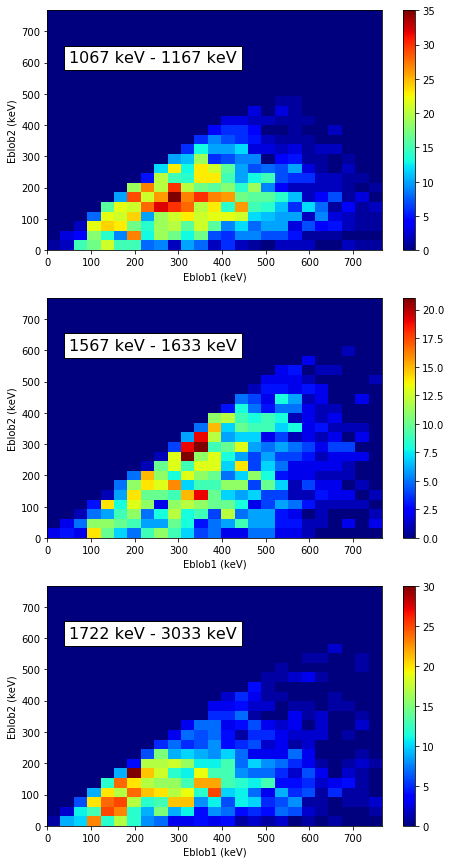

In [185]:
# Plot Eblob1 vs. Eblob2 in several intervals
nbins_blobs = 25

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(7.5);

# define intervals
eb1_low = 320000; eb1_high = 350000
eb2_low = 470000; eb2_high = 490000
eb3_low = 516600; eb3_high = 910000

# axes
ax_low = 15000; ax_high = 195000

# histogram range
hrange = 230000

# cuts
cuts_1 = ((l_etrk > eb1_low) & (l_etrk < eb1_high))
cuts_2 = ((l_etrk > eb2_low) & (l_etrk < eb2_high))
cuts_3 = ((l_etrk > eb3_low) & (l_etrk < eb3_high))

print("Number of events I1 ({0} keV, {1} keV): {2}".format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR,len(l_eblob1[cuts_1])))
print("Number of events I2 ({0} keV, {1} keV): {2}".format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR,len(l_eblob1[cuts_2])))
print("Number of events I3 ({0} keV, {1} keV): {2}".format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR,len(l_eblob1[cuts_3])))

# interval 1
ax1 = fig.add_subplot(311);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_1]*CAL_FACTOR, l_eblob2[cuts_1]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax1.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb1_low*CAL_FACTOR,eb1_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("Eblob1 (keV)")
ax1.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp1)

# interval 2
ax2 = fig.add_subplot(312);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_2]*CAL_FACTOR, l_eblob2[cuts_2]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax2.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb2_low*CAL_FACTOR,eb2_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent2 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp2 = ax2.imshow(hxy, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("Eblob1 (keV)")
ax2.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp2)

# interval 3
ax3 = fig.add_subplot(313);
hxy, xxy, yxy = np.histogram2d(l_eblob1[cuts_3]*CAL_FACTOR, l_eblob2[cuts_3]*CAL_FACTOR, normed=False, bins=(nbins_blobs, nbins_blobs), range=[[0,hrange*CAL_FACTOR],[0,hrange*CAL_FACTOR]])
ax3.text(50, 600, '{0:.4g} keV - {1:.4g} keV'.format(eb3_low*CAL_FACTOR,eb3_high*CAL_FACTOR), 
         bbox={'facecolor':'white', 'alpha':1.0, 'pad':5},fontsize=16)
extent3 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp3 = ax3.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("Eblob1 (keV)")
ax3.set_ylabel("Eblob2 (keV)")
plt.colorbar(sp3)

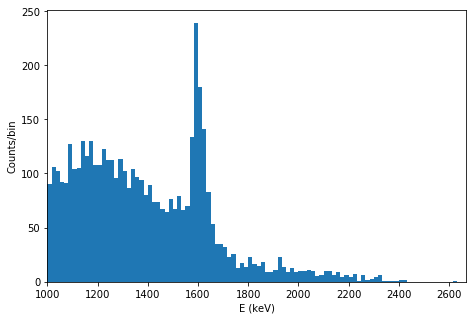

In [184]:
# track-energy spectrum
#CAL_FACTOR = 1600/486000
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

#y, x, _ = plt.hist(ecorr_slice_spec, 100, range=[300000,800000])
y, x, _ = plt.hist(l_etrk[l_eblob1 > 200/CAL_FACTOR]*CAL_FACTOR, 100, range=[300000*CAL_FACTOR,800000*CAL_FACTOR])

x    = x[:-1] + np.diff(x) * 0.5
sel  = fitf.in_range(x, 465e3*CAL_FACTOR, 495e3*CAL_FACTOR)
x, y = x[sel], y[sel]
f    = fitf.fit(fitf.gauss, x, y, (200, 480000*CAL_FACTOR, 10000*CAL_FACTOR))
#plt.plot(x, f.fn(x), "r")
#plt.text(510000*CAL_FACTOR, 5*max(y)/6, gausstext(f.values))

#plt.hist(ecorr_slice_spec,bins=200)
#plt.ylim([100000,900000])
plt.xlim([300000*CAL_FACTOR,800000*CAL_FACTOR])
plt.xlabel('E (keV)')
plt.ylabel('Counts/bin')

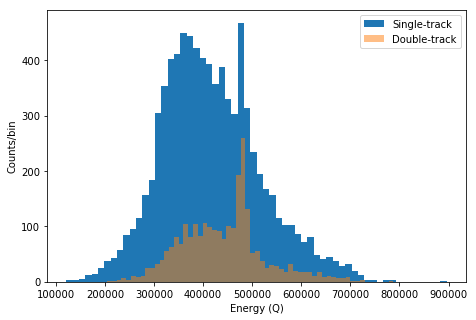

In [31]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

ax1 = fig.add_subplot(111);
plt.hist(l_etrk[l_eblob1 < 200/CAL_FACTOR],bins=60,label='Single-track')
plt.hist(l_etrk[l_eblob1 > 200/CAL_FACTOR],bins=60,alpha=0.5,label='Double-track')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q)')
plt.ylabel('Counts/bin')

Running Paolina for event 24 with blob radius 21.0
Event 24 with total energy 1519.6839268313415
Found 1 tracks; max containing 23 voxels; total of 23 voxels
Found 1 tracks of 26560; max containing 23 voxels; total of 23 voxels, distance = 84.29064682296152
Extreme0 at (-3.4877580844179246,190.9819890237577,194.3869140625) with energy 38.46008405750463 keV
Extreme1 at (-31.234708169493985,149.1955269387388,171.38457031250002) with energy 263.3891655485008 keV


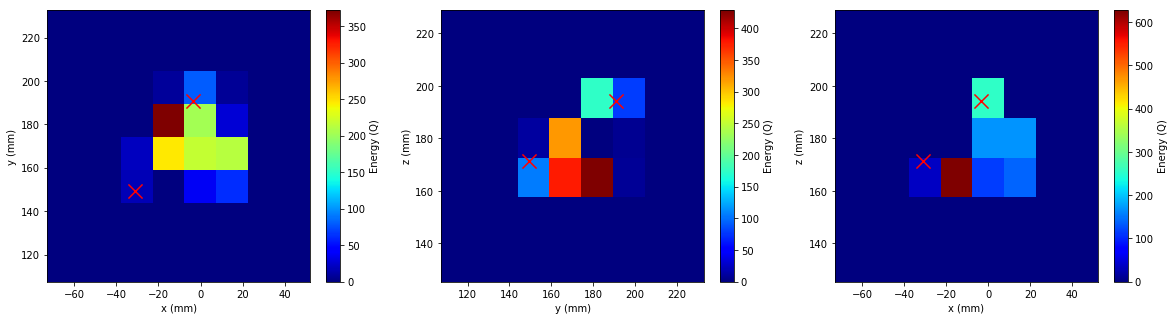

In [80]:
vox_size = np.array([15,15,15],dtype=np.int16)    # voxel size
blob_radius = 21.                    # blob radius in mm

nevt = 24
hitc = hitc_cevt[nevt]
print("Running Paolina for event {0} with blob radius {1}".format(nevt,blob_radius))

evt_E = sum([hh.E for hh in hitc])
print("Event {0} with total energy {1}".format(nevt,evt_E*CAL_FACTOR))

voxels = plf.voxelize_hits(hitc,vox_size)
trks = plf.make_track_graphs(voxels,vox_size)
for t in trks:
    etrk = sum([vox.E for vox in t.nodes()])
    trk_energies.append(etrk)
itmax = np.argmax([len(t) for t in trks])
print("Found {0} tracks; max containing {1} voxels; total of {2} voxels".format(len(trks),len(trks[itmax]),len(voxels)))

eblobs = plf.blob_energies(trks[itmax],blob_radius)
iter_eblobs = iter(eblobs)
if(len(eblobs) > 1):
    Eblob1, Eblob2 = next(iter_eblobs), next(iter_eblobs)
else:
    Eblob1 = Eblob2 = next(iter_eblobs)

# get the extremes
distances = plf.shortest_paths(trks[itmax])
exts = plf.find_extrema(distances)
iter_exts = iter(exts)
if(len(exts) > 1):
    a,b = next(iter_exts),next(iter_exts)
else:
    a = b = next(iter_exts)
print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_cevt),len(trks[itmax]),len(voxels),distances[a][b]))
    
# plot the voxelized tracks
# 2D histogram
fig = plt.figure(3);
fig.set_figheight(5.0);
fig.set_figwidth(20.0);

varr_x = []; varr_y = []; varr_z = []; varr_c = []
#for vv in trks[itmax]:
for vv in voxels:
    varr_x.append(vv.pos[0])
    varr_y.append(vv.pos[1])
    varr_z.append(vv.pos[2])
    varr_c.append(vv.E*CAL_FACTOR)
    
vtrk_max = 1.0*np.array([np.max(varr_x),np.max(varr_y),np.max(varr_z)])
vtrk_min = 1.0*np.array([np.min(varr_x),np.min(varr_y),np.min(varr_z)])
vtrk_len = np.abs(vtrk_max-vtrk_min)
vtrk_max = vtrk_max + 1.0*vtrk_len
vtrk_min = vtrk_min - 1.0*vtrk_len

# create the x-y projection
ax1 = fig.add_subplot(131);
hxy, xxy, yxy = np.histogram2d(varr_y, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[1]-vol_min[1])/vox_size[1], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[1],vol_max[1]],[vol_min[0],vol_max[0]]])
extent1 = [yxy[0], yxy[-1], xxy[0], xxy[-1]]
sp1 = ax1.imshow(hxy, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_xlim([vtrk_min[0],vtrk_max[0]])
ax1.set_ylim([vtrk_min[1],vtrk_max[1]])
cbp1 = plt.colorbar(sp1)
cbp1.set_label('Energy (Q)')
ax1.scatter(a.pos[0],a.pos[1],marker='x',s=200,color='red')
ax1.scatter(b.pos[0],b.pos[1],marker='x',s=200,color='red')

# Create the y-z projection.
ax2 = fig.add_subplot(132)
hyz, xyz, yyz = np.histogram2d(varr_z, varr_y, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[1]-vol_min[1])/vox_size[1]), range=[[vol_min[2],vol_max[2]],[vol_min[1],vol_max[1]]])
extent2 = [yyz[0], yyz[-1], xyz[0], xyz[-1]]
sp2 = ax2.imshow(hyz, extent=extent2, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax2.set_xlabel("y (mm)")
ax2.set_ylabel("z (mm)")
ax2.set_xlim([vtrk_min[1],vtrk_max[1]])
ax2.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp2 = plt.colorbar(sp2)
cbp2.set_label('Energy (Q)')
ax2.scatter(a.pos[1],a.pos[2],marker='x',s=200,color='red')
ax2.scatter(b.pos[1],b.pos[2],marker='x',s=200,color='red')

# Create the x-z projection.
ax3 = fig.add_subplot(133);
hxz, xxz, yxz = np.histogram2d(varr_z, varr_x, weights=varr_c, normed=False, bins=(1.0*(vol_max[2]-vol_min[2])/vox_size[2], 1.0*(vol_max[0]-vol_min[0])/vox_size[0]), range=[[vol_min[2],vol_max[2]],[vol_min[0],vol_max[0]]])
extent3 = [yxz[0], yxz[-1], xxz[0], xxz[-1]]
sp3 = ax3.imshow(hxz, extent=extent3, interpolation='none', aspect='auto', origin='lower', cmap='jet')
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("z (mm)")
ax3.set_xlim([vtrk_min[0],vtrk_max[0]])
ax3.set_ylim([vtrk_min[2],vtrk_max[2]])
cbp3 = plt.colorbar(sp3);
cbp3.set_label('Energy (Q)');
ax3.scatter(a.pos[0],a.pos[2],marker='x',s=200,color='red')
ax3.scatter(b.pos[0],b.pos[2],marker='x',s=200,color='red')

print("Extreme0 at ({0},{1},{2}) with energy {3} keV".format(a.pos[0],a.pos[1],a.pos[2],Eblob1*CAL_FACTOR))
print("Extreme1 at ({0},{1},{2}) with energy {3} keV".format(b.pos[0],b.pos[1],b.pos[2],Eblob2*CAL_FACTOR))

------------------------------------------------------------------

# Old misc. code

In [ ]:
# plot a PMap slice
slice_no = 14
evt_no = 313
peak_no = 0

filename = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Na/dst_NEXT_v0_08_09_Na_INTERNALPORTANODE_0_0_7bar_pmaps_10000.root.h5"
try:
    S1s, S2s, S2Sis = load_pmaps(filename)
except (ValueError, tb.exceptions.NoSuchNodeError):
    print("Empty file {0}. Skipping.".format(ifile))

S2 = S2s  .get(evt_no, {})
S1 = S1s  .get(evt_no, {})
Si = S2Sis.get(evt_no, {})
si = Si[peak_no]

t, e = next(iter(S1.values()))
S1t  = t[np.argmax(e)]

t_slice = S2[0][0][slice_no]
z        = (t_slice - S1t) * units.ns * 0.001  # drift_v = 1.0

clusters = compute_xy_position(si, slice_no)
print("Found {0} clusters".format(len(clusters)))

x0vals = []; y0vals = []
for c in clusters:
    x0vals.append(c.pos[0])
    y0vals.append(c.pos[1])
    print("cluster ({0},{1},{2})".format(c.pos[0],c.pos[1],z))
    
xvals = []; yvals = []; qvals = []
for s in si.items():
    xvals.append(data_xs[s[0]])
    yvals.append(data_ys[s[0]])
    qvals.append(s[1][slice_no])
    #print(s[1])
    
plot_test_event(xvals,yvals,qvals,x0vals,y0vals)

### Plot the generated correction factors

In [ ]:
corr_file_MC = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/MC/Kr/mcKr.corr"
corr_file_data_dnn = "/Users/jrenner/IFIC/IC-1/invisible_cities/cities/corr_r4236.h5" 
corr_file_data = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236_b30.corr"
fcorr_MC = tb.open_file(corr_file_MC,'r')
fcorr_data = tb.open_file(corr_file_data,'r')
fcorr_data_dnn = tb.open_file(corr_file_data_dnn,'r')

mcorr_x = []; mcorr_y = []; mcorr_fs = []; mcorr_us = []; mcorr_nevt = []
mxyc = fcorr_MC.root.Corrections.XYcorrections
for r in range(len(mxyc)):
    mcorr_x.append(mxyc[r]['x'])
    mcorr_y.append(mxyc[r]['y'])
    mcorr_fs.append(mxyc[r]['factor'])
    mcorr_us.append(mxyc[r]['uncertainty'])
    mcorr_nevt.append(mxyc[r]['nevt'])
mcorr_x = np.array(mcorr_x)
mcorr_y = np.array(mcorr_y)
mcorr_fs = np.array(mcorr_fs)
mcorr_us = np.array(mcorr_us)
mcorr_nevt = np.array(mcorr_nevt)
maxf_mc = np.max(mcorr_fs)
print("Total MC stats = {0}".format(np.sum(mcorr_nevt)))

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr_data.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
corr_x = np.array(corr_x)
corr_y = np.array(corr_y)
corr_fs = np.array(corr_fs)
corr_us = np.array(corr_us)
corr_nevt = np.array(corr_nevt)
maxf_data = np.max(corr_fs)
print("Total data stats = {0}".format(np.sum(corr_nevt)))

dcorr_x = []; dcorr_y = []; dcorr_fs = []; dcorr_us = []; dcorr_nevt = []
dxyc = fcorr_data_dnn.root.Corrections.XYcorrections
for r in range(len(dxyc)):
    dcorr_x.append(dxyc[r]['x'])
    dcorr_y.append(dxyc[r]['y'])
    dcorr_fs.append(dxyc[r]['factor'])
    dcorr_us.append(dxyc[r]['uncertainty'])
    dcorr_nevt.append(dxyc[r]['nevt'])
dcorr_x = np.array(dcorr_x)
dcorr_y = np.array(dcorr_y)
dcorr_fs = np.array(dcorr_fs)
dcorr_us = np.array(dcorr_us)
dcorr_nevt = np.array(dcorr_nevt)
maxf_data_dnn = np.max(dcorr_fs)
print("Total data DNN stats = {0}".format(np.sum(dcorr_nevt)))

fig = plt.figure(3);
fig.set_figheight(15.0);
fig.set_figwidth(18.0);

# correction factor (MC)
ax1 = fig.add_subplot(331);
ax1.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax1.set_title("Correction factor (MC, DST)")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error (MC)
ax2 = fig.add_subplot(332)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_us, cmap='jet')
plt.colorbar()
ax2.set_title("Correction factor error (MC, DST)")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

# correction factor statistics (MC)
ax3 = fig.add_subplot(333)
#plt.axes().set_aspect('equal')
ax3.set_aspect('equal')
plt.hist2d(mcorr_x, mcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=mcorr_nevt, cmap='jet')
plt.colorbar()
ax3.set_title("Correction factor # events (MC, DST)")
ax3.set_xlabel("x (mm)")
ax3.set_ylabel("y (mm)")

ax4 = fig.add_subplot(334)
ax4.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs, cmap='jet', vmin=0, vmax=max(maxf_mc,maxf_data,maxf_data_dnn))
plt.colorbar()
ax4.set_title("Correction factor (run 4236, DST)")
ax4.set_xlabel("x (mm)")
ax4.set_ylabel("y (mm)")

ax5 = fig.add_subplot(335)
ax5.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us, cmap='jet')
plt.colorbar()
ax5.set_title("Correction factor error (run 4236, DST)")
ax5.set_xlabel("x (mm)")
ax5.set_ylabel("y (mm)")

ax6 = fig.add_subplot(336)
ax6.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_nevt, cmap='jet')
plt.colorbar()
ax6.set_title("Correction factor # events (run 4236, DST)")
ax6.set_xlabel("x (mm)")
ax6.set_ylabel("y (mm)")

ax7 = fig.add_subplot(337)
ax7.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_fs, cmap='jet', vmin=0, vmax=max(maxf_data_dnn,maxf_mc,maxf_data))
plt.colorbar()
ax7.set_title("Correction factor (run 4236, DNN)")
ax7.set_xlabel("x (mm)")
ax7.set_ylabel("y (mm)")

ax8 = fig.add_subplot(338)
ax8.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_us, cmap='jet')
plt.colorbar()
ax8.set_title("Correction factor error (run 4236, DNN)")
ax8.set_xlabel("x (mm)")
ax8.set_ylabel("y (mm)")

ax9 = fig.add_subplot(339)
ax9.set_aspect('equal')
plt.hist2d(dcorr_x, dcorr_y, (30, 30), ((-215, 215), (-215, 215)), weights=dcorr_nevt, cmap='jet')
plt.colorbar()
ax9.set_title("Correction factor # events (run 4236, DNN)")
ax9.set_xlabel("x (mm)")
ax9.set_ylabel("y (mm)")

#ax1 = fig.add_subplot(121);
#extent1 = [-215., 215., -215., 215]
#sp2 = plt.imshow(h2d, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)
#ax2 = fig.add_subplot(122)
#sp2 = plt.imshow(h2d_err, extent=extent1, interpolation='none', aspect='auto', origin='lower', cmap='jet')
#cbp2 = plt.colorbar(sp2)

fcorr_MC.close()
fcorr_data.close()

In [ ]:
corr_file = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4236/kr4236.corr"
fcorr = tb.open_file(corr_file,'r')

corr_x = []; corr_y = []; corr_fs = []; corr_us = []; corr_nevt = []
xyc = fcorr.root.Corrections.XYcorrections
for r in range(len(xyc)):
    corr_x.append(xyc[r]['x'])
    corr_y.append(xyc[r]['y'])
    corr_fs.append(xyc[r]['factor'])
    corr_us.append(xyc[r]['uncertainty'])
    corr_nevt.append(xyc[r]['nevt'])
    
fig = plt.figure(4);
fig.set_figheight(5.0);
fig.set_figwidth(15.0);

# correction factor fs
ax1 = fig.add_subplot(121);
ax1.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_fs)
plt.colorbar()
ax1.set_title("Correction factor")
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")

# correction factor error
ax2 = fig.add_subplot(122)
#plt.axes().set_aspect('equal')
ax2.set_aspect('equal')
plt.hist2d(corr_x, corr_y, (30, 30), ((-215, 215), (-215, 215)), weights=corr_us)
plt.colorbar()
ax2.set_title("Correction factor error")
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")

In [ ]:
# Initial look at run 4264
fn = tb.open_file('/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/4264/dst/dst_4264.root.h5','r')

# plot the S2 spectrum
s2arr = fn.root.DST.Events[:]['S2e']

fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(s2arr,bins=500)
lnd = plt.legend(loc=1)
plt.xlabel('Energy')
plt.ylabel('Counts/bin')
#plt.xlim([1000,40000])

In [ ]:
# run Paolina for many events
trk_energies = [];
l_eblob1 = []; l_eblob2 = []
for nevt in range(len(hitc_evt)):
#for nevt in range(1000):
    
    hitc = hitc_evt[nevt]
    if(len(hitc) < 2): continue
    
    # Calculate event coordinates and corrected energy.
    evt_X = sum([hh.X*hh.E for hh in hitc_evt[nevt]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_evt[nevt]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_evt[nevt]])
    if(len(hitc_evt[nevt]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_evt[nevt]])/np.exp(-evt_Z/tlife)
    
    # Make energy and radial cuts.
    if(not (evt_Ecorrtau_xy_slice > ECCUT_LOW and evt_Ecorrtau_xy_slice < ECCUT_HIGH) or evt_R >= 150.):
        continue
        
    #for h in hitc:
    #    print("Hit ({0},{1},{2},{3})".format(h.pos[0],h.pos[1],h.pos[2],h.E))
    #print("Event {0} with total energy {1}".format(nevt,evt_E))

    print("Track {0} with {1} hits...".format(nevt,len(hitc)))

    voxels = plf.voxelize_hits(hitc,vox_size)
    trks = plf.make_track_graphs(voxels,vox_size)
    for t in trks:
        etrk = sum([vox.E for vox in t.nodes()])
        trk_energies.append(etrk)
    itmax = np.argmax([len(t) for t in trks])
    if(len(trks[itmax])/len(voxels) < 0.95):
        continue

    eblobs = plf.blob_energies(trks[itmax],blob_radius)
    iter_eblobs = iter(eblobs)
    Eblob1, Eblob2 = next(iter_eblobs),next(iter_eblobs)

    # ensure blob2 always has higher energy
    if(Eblob1 > Eblob2):
        eswap = Eblob1
        Eblob1 = Eblob2
        Eblob2 = eswap

    # get the extremes
    distances = plf.shortest_paths(trks[itmax])
    a,b = plf.find_extrema(distances)
    if(distances[a][b] < DIST_CUT): continue
    print("Found {0} tracks of {1}; max containing {2} voxels; total of {3} voxels, distance = {4}".format(len(trks),len(hitc_evt),len(trks[itmax]),len(voxels),distances[a][b]))
    
    # add distribution information (event-scale)
    l_eblob1.append(Eblob1)
    l_eblob2.append(Eblob2)
    
l_eblob1.append(250000)
l_eblob2.append(250000)

l_eblob1 = np.array(l_eblob1)
l_eblob2 = np.array(l_eblob2)

In [ ]:
l_rnum = [4595]

l_hitc = []
for rnum in l_rnum:
    # Create a dictionary of HitCollection objects, one per event.
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    dst = load_dst(fname,'RECO','Events')
    
    all_events = {}

    event = dst.event.values
    time  = dst.time .values
    npeak = dst.npeak.values
    nsipm = dst.nsipm.values
    X     = dst.X    .values
    Y     = dst.Y    .values
    Xrms  = dst.Xrms .values
    Yrms  = dst.Yrms .values
    Z     = dst.Z    .values
    Q     = dst.Q    .values
    E     = dst.E    .values

    dst_size = len(dst)
    #limit = np.iinfo(int).max if max_events < 0 else max_events
    for i in range(dst_size):
        #if event[i] >= limit: break
        current_event = all_events.setdefault(event[i], HitCollection(event[i], time[i] * 1e-3)      )
        hit = Hit(npeak[i], Cluster(Q[i], xy(X[i],Y[i]), xy(Xrms[i],Yrms[i]), nsipm[i], Z[i], E[i]), Z[i], E[i])
        current_event.hits.append(hit)
        
    l_hitc.append(all_events)

In [ ]:
l_NNfrac = []
for evt,hc in hits.items():
    
    E_tot = 0
    E_NN = 0
    for hh in hc.hits:
        if(hh.Q == NN):
            E_NN += hh.E
        E_tot += hh.E
    
    l_NNfrac.append(E_NN/E_tot)

In [ ]:
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(7.5)

plt.hist(l_NNfrac,bins=100,label='$E_{NN}/E_{tot}$')
#lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('NN fraction')
plt.ylabel('Counts/bin')
plt.title('Fraction of energy in NN hits (run 4595)')

In [ ]:
l_rnum = [4595]

for rnum in l_rnum:
    # Create a dictionary of HitCollection objects, one per event.
    
    fname = "/Users/jrenner/IFIC/IC-1/invisible_cities/database/NEW/{0}/tracks/tracks_{1}.h5".format(rnum,rnum)
    hits = load_hits()
    

In [ ]:
# energy spectrum
ec_spec = []; rc_spec = []; zc_spec = []; evtNumc_spec = []
eccorr_avg_spec = []; eccorr_tau_spec = []; eccorr_slice_spec = []
for ee in range(len(hitc_cevt)):
    evt_E = sum([hh.E for hh in hitc_cevt[ee]])
    evt_X = sum([hh.X*hh.E for hh in hitc_cevt[ee]])
    evt_Y = sum([hh.Y*hh.E for hh in hitc_cevt[ee]])
    evt_Z = sum([hh.Z*hh.E for hh in hitc_cevt[ee]])
    if(len(hitc_cevt[ee]) > 0):
        evt_X /= evt_E
        evt_Y /= evt_E
        evt_Z /= evt_E
    evt_Ecorrtau = evt_E/np.exp(-evt_Z/tlife)
    evt_Ecorrtau_xy = evt_Ecorrtau*fcorr(evt_X,evt_Y)
    evt_Ecorrtau_xy_slice = sum([hh.E*fcorr(hh.X,hh.Y) for hh in hitc_cevt[ee]])/np.exp(-evt_Z/tlife)
    evt_R = np.sqrt(evt_X**2 + evt_Y**2)
    evt_Emc = 0
    if(evt_E > emin_hist and evt_E < emax_hist and
       evt_Ecorrtau > emin_hist and evt_Ecorrtau < emax_hist and
       evt_Ecorrtau_xy > emin_hist and evt_Ecorrtau_xy < emax_hist and
       evt_Ecorrtau_xy_slice > emin_hist and evt_Ecorrtau_xy_slice < emax_hist and
       evt_R < 250.): #hr.all()):
        ec_spec.append(evt_E)
        rc_spec.append(evt_R)
        zc_spec.append(evt_Z)
        eccorr_tau_spec.append(evt_Ecorrtau)
        eccorr_avg_spec.append(evt_Ecorrtau_xy)
        eccorr_slice_spec.append(evt_Ecorrtau_xy_slice)
        evtNumc_spec.append(evtnum_hitc[ee])

rc_spec = np.array(rc_spec)
zc_spec = np.array(zc_spec)
ec_spec = np.array(ec_spec)
eccorr_tau_spec = np.array(eccorr_tau_spec)
eccorr_avg_spec = np.array(eccorr_avg_spec)
eccorr_slice_spec = np.array(eccorr_slice_spec)
evtNumc_spec = np.array(evtNumc_spec)

fig = plt.figure(1)
fig.set_figheight(10.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(221);
plt.hist(ec_spec/npmts,bins=ebins,label='Event energies')
lnd = plt.legend(loc=1)
#plt.scatter(z_spec,e_spec,marker='.')
#plt.ylim([100000,900000])
#plt.xlim([20000,160000])
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax2 = fig.add_subplot(222)
plt.hist(eccorr_tau_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax3 = fig.add_subplot(223)
plt.hist(eccorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-avg)'.format(tlife))
#plt.hist(ecorr_avg_spec/npmts,bins=ebins,label='Corrected ($\\tau = {0} \mu s$, xy-avg)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

ax4 = fig.add_subplot(224)
plt.hist(eccorr_slice_spec/npmts,bins=ebins,label='Corrected ($\\tau$, xy-cluster)'.format(tlife))
#plt.hist(ecorr_slice_spec/npmts,bins=ebins,label='Corr. ($\\tau = {0} \mu s$, xy-cluster)'.format(tlife))
#plt.scatter(z_spec,ecorr_spec,alpha=0.5,marker='.')
lnd = plt.legend(loc=1)
plt.xlabel('Energy (Q/PMT)')
plt.ylabel('Counts/bin')

In [ ]:
# plot the clusters in 3D
carr_x = []; carr_y = []; carr_z = []; carr_c = []
for cc in hitc:
    if(cc.E > 1):
        carr_x.append(cc.X)
        carr_y.append(cc.Y)
        carr_z.append(cc.Z)
        carr_c.append(cc.E)

mcarr_x = []; mcarr_y = []; mcarr_z = []; mcarr_c = []
if(nevt < len(hitc_mc)):
    hitcm = hitc_mc[nevt]
    for cc in hitcm:
        mcarr_x.append(cc.X)
        mcarr_y.append(cc.Y)
        mcarr_z.append(cc.Z)
        mcarr_c.append(cc.E)

print(sum(mcarr_c))
fig = plt.figure(1)
fig.set_figheight(5.0)
fig.set_figwidth(15.0)

# true track
ax1 = fig.add_subplot(121, projection='3d')
sc3d = ax1.scatter(mcarr_x,mcarr_y,mcarr_z,marker='s',cmap='jet',c=mcarr_c)
xst, xen = ax1.get_xlim(); ax1.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax1.get_ylim(); ax1.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax1.get_zlim(); ax1.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax1.set_xlabel("x (mm)")
ax1.set_ylabel("y (mm)")
ax1.set_zlabel("z (mm)")
ax1.set_title("True Track")
lb_x = ax1.get_xticklabels()
lb_y = ax1.get_yticklabels()
lb_z = ax1.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (MeV)')

# reconstructed clusters
ax2 = fig.add_subplot(122, projection='3d')
sc3d = ax2.scatter(carr_x,carr_y,carr_z,marker='s',cmap='jet',c=carr_c)
xst, xen = ax2.get_xlim(); ax2.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
yst, yen = ax2.get_ylim(); ax2.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
zst, zen = ax2.get_zlim(); ax2.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
ax2.set_xlabel("x (mm)")
ax2.set_ylabel("y (mm)")
ax2.set_zlabel("z (mm)")
ax2.set_title("Reconstructed Clusters")
lb_x = ax2.get_xticklabels()
lb_y = ax2.get_yticklabels()
lb_z = ax2.get_zticklabels()
for lb in (lb_x + lb_y + lb_z):
    lb.set_fontsize(8.)
cbp1 = plt.colorbar(sc3d)
cbp1.set_label('Energy (Q)')

# Paolina track
#ax3 = fig.add_subplot(133, projection='3d')
#sc3d = ax3.scatter(varr_x,varr_y,varr_z,marker='s',cmap='jet',c=varr_c)
#xst, xen = ax3.get_xlim(); ax3.xaxis.set_ticks(np.arange(xst,xen,(xen-xst)/5.))
#yst, yen = ax3.get_ylim(); ax3.yaxis.set_ticks(np.arange(yst,yen,(yen-yst)/5.))
#zst, zen = ax3.get_zlim(); ax3.zaxis.set_ticks(np.arange(zst,zen,(zen-zst)/5.))
#ax3.set_xlabel("x (mm)")
#ax3.set_ylabel("y (mm)")
#ax3.set_zlabel("z (mm)")
#ax3.set_title("Paolina Track")
#lb_x = ax3.get_xticklabels()
#lb_y = ax3.get_yticklabels()
#lb_z = ax3.get_zticklabels()
#for lb in (lb_x + lb_y + lb_z):
#    lb.set_fontsize(8.)
#cbp1 = plt.colorbar(sc3d)
#cbp1.set_label('Energy (Q)')